# World Data League 2021
## Stage 2
### Challenge: Patterns and predictive modelling of traffic accidents

#### Team: I Bellissimi di Rete 4 (Arcudi Alessio, Padella Alessandro, Pozzan Matteo, Vinci Francesco)

## External links and resources

10 wards within the City of Kitchener (geopandas)
https://opendata.arcgis.com/datasets/aaa70fb878304de4ba244f12c5447016_0.geojson


Traffic collisions in the City of Kitchener(geopandas):
https://opendata.arcgis.com/datasets/75fa68b17e5b421d9d881f987c2d43fc_0.geojson

Streets of the City of Kitchener (geopandas):
https://opendata.arcgis.com/datasets/75fa68b17e5b421d9d881f987c2d43fc_0.geojson

https://data.waterloo.ca/datasets/KitchenerGIS::roads?geometry=-80.818%2C43.340%2C-80.123%2C43.514 to download the "csv" file.

Weather: https://climate.weather.gc.ca/climate_data/daily_data_e.html?hlyRange=%7C&dlyRange=1972-10-01%7C2021-04-29&mlyRange=1972-01-01%7C2006-12-01&StationID=4816&Prov=ON&urlExtension=_e.html&searchType=stnProx&optLimit=yearRange&StartYear=2005&EndYear=2018&selRowPerPage=25&Line=3&txtRadius=25&optProxType=city&selCity=43%7C27%7C80%7C29%7CKitchener&selPark=&txtCentralLatDeg=&txtCentralLatMin=0&txtCentralLatSec=0&txtCentralLongDeg=&txtCentralLongMin=0&txtCentralLongSec=0&txtLatDecDeg=&txtLongDecDeg=&timeframe=2&Day=30&Year=2014&Month=4#


## Introduction
In the idea of smart cities, one of the fondant pilasters is for sure the safety of the people who lived in; using the data related to the 
Kitchener roads (Canada), weather conditions, previous accidents, and part of the year we tried to build a model which has a risk probability of accident as output.
In the first and analytic part of our study, we perform some descriptive analysis to better understand the data and the attributes of the accidents. Then our goal became to build a regressor to predict the risk of car crashes on a road. To do that we needed a complete dataset composed of accident and non-accident instances, so we had to generate non-accident instances. Finally, we tried some different machine-learning tools that are aimed at better represents our data.

## Development

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
plt.rcParams.update({'font.size': 12})

PROJ: proj_create_from_database: SQLite error on SELECT key, value FROM metadata WHERE key IN ('DATABASE.LAYOUT.VERSION.MAJOR', 'DATABASE.LAYOUT.VERSION.MINOR'): no such table: metadata


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

Dataset with traffic collisions, from 2005 to 2017, of the city of Kitchener (Canada).

In [3]:
TC = gpd.read_file("Traffic_Collisions.geojson")
TC.index=TC['OBJECTID']
TC=TC.drop(['OBJECTID'], axis=1)
TC.head()

,ACCIDENTNUM,ACCIDENTDATE,LOCATION,ACCIDENT_LOCATION,IMPACT_LOCATION,ENVIRONMENT_CONDITION,LIGHT,COLLISION_TYPE,TRAFFICCOLLISIONSID,geometry
OBJECTID,,,,,,,,,,
1,13-118637,20130525,CEDAR ST N @ KING ST E / CEDAR ST S,02-Intersection related,02-Thru lane,01-Clear,01-Daylight,INTERSECTION,None,MULTIPOINT (-80.48344 43.44734)
2,13-019811,20130124,GLASGOW ST @ BELMONT AVE W,04-At/near private drive,02-Thru lane,01-Clear,01-Daylight,INTERSECTION,None,MULTIPOINT (-80.51699 43.45189)
3,12-089689,20120418,CEDAR ST N @ KING ST E / CEDAR ST S,01-Non intersection,09-Right shoulder,01-Clear,01-Daylight,INTERSECTION,None,MULTIPOINT (-80.48344 43.44734)
4,12-127500,20120601,BELMONT AVE W @ ARGYLE ST,03-At intersection,01-Within intersection,02-Rain,01-Daylight,INTERSECTION,None,MULTIPOINT (-80.51844 43.45418)
5,13-012564,20130115,STRASBURG RD @ HURON RD,03-At intersection,01-Within intersection,01-Clear,"08-Dark, artificial",INTERSECTION,None,MULTIPOINT (-80.46622 43.39197)


### Digging into data
Looking into the dataset, we can find relevant information as:
* distribution of accidents through years
* when they happened (month and day)
* accident and impact location
* weather and type of light of the day of the accidents



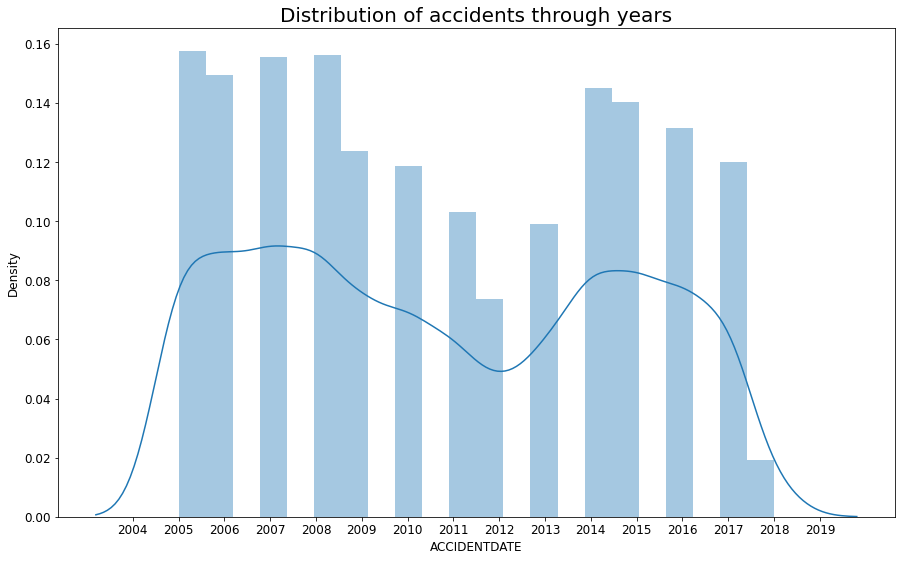

In [4]:
def extract_year(date):
    return int(str(date)[:4])

plt.figure(figsize=(15,9))
sns.distplot(TC['ACCIDENTDATE'].apply(extract_year))
plt.title('Distribution of accidents through years', size=20)
plt.xticks([x for x in range(2004, 2020)])
plt.show()

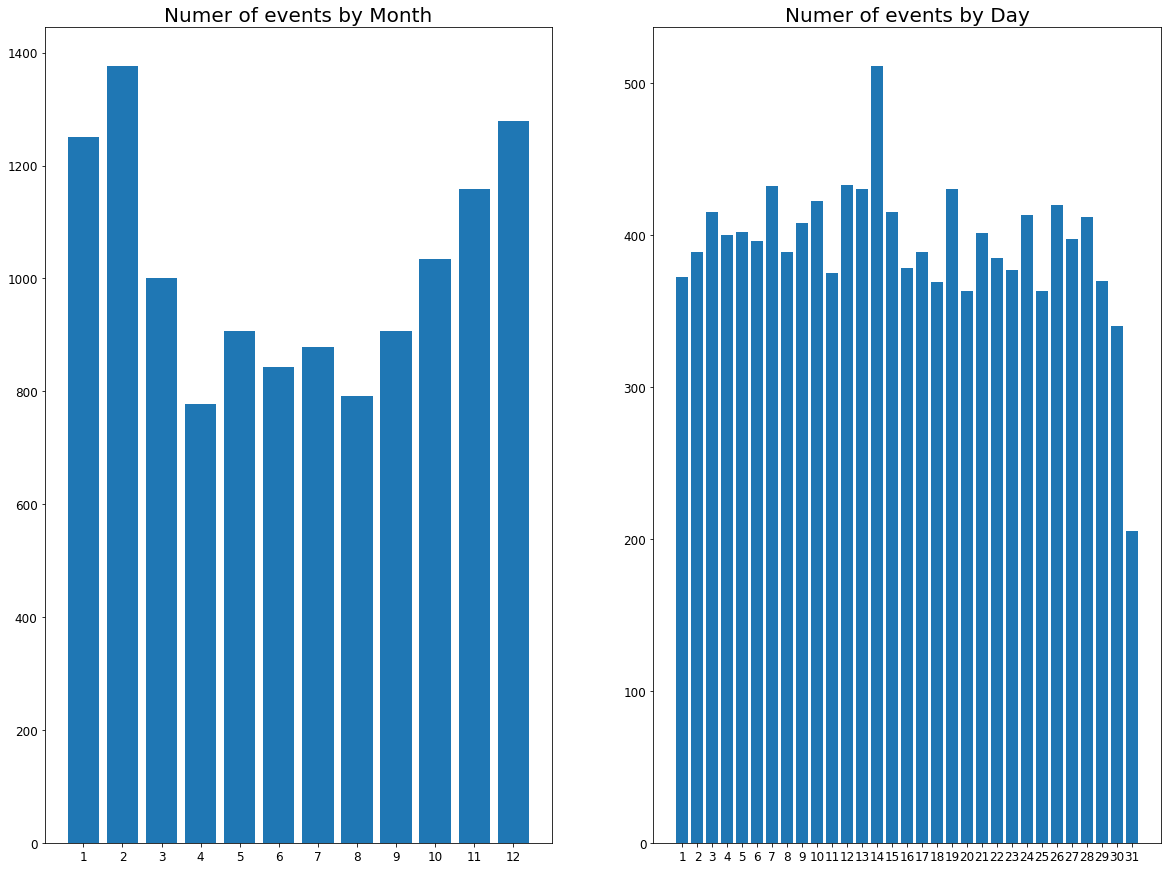

In [5]:
def extract_day(date):
    return int(str(date)[6:8])

day_count = {y : list(TC['ACCIDENTDATE'].apply(extract_day)).count(y) for y in sorted(TC['ACCIDENTDATE'].apply(extract_day).unique())}

def extract_month(date):
    return int(str(date)[4:6])

month_count = {y : list(TC['ACCIDENTDATE'].apply(extract_month)).count(y) for y in sorted(TC['ACCIDENTDATE'].apply(extract_month).unique())}

fig, ax = plt.subplots( 1,2, figsize=(20,15))
ax[1].bar(day_count.keys(), day_count.values())
ax[1].set_xticks([x for x in range(1, 32)])
ax[0].bar(month_count.keys(), month_count.values())
ax[0].set_xticks([x for x in range(1, 13)])

ax[0].set_title('Numer of events by Month', size=20)
ax[1].set_title('Numer of events by Day', size=20)
plt.show()

The majority of accidents happened during winter, from December to February. It's curious to see that majority of events happened on the 14th of every month.

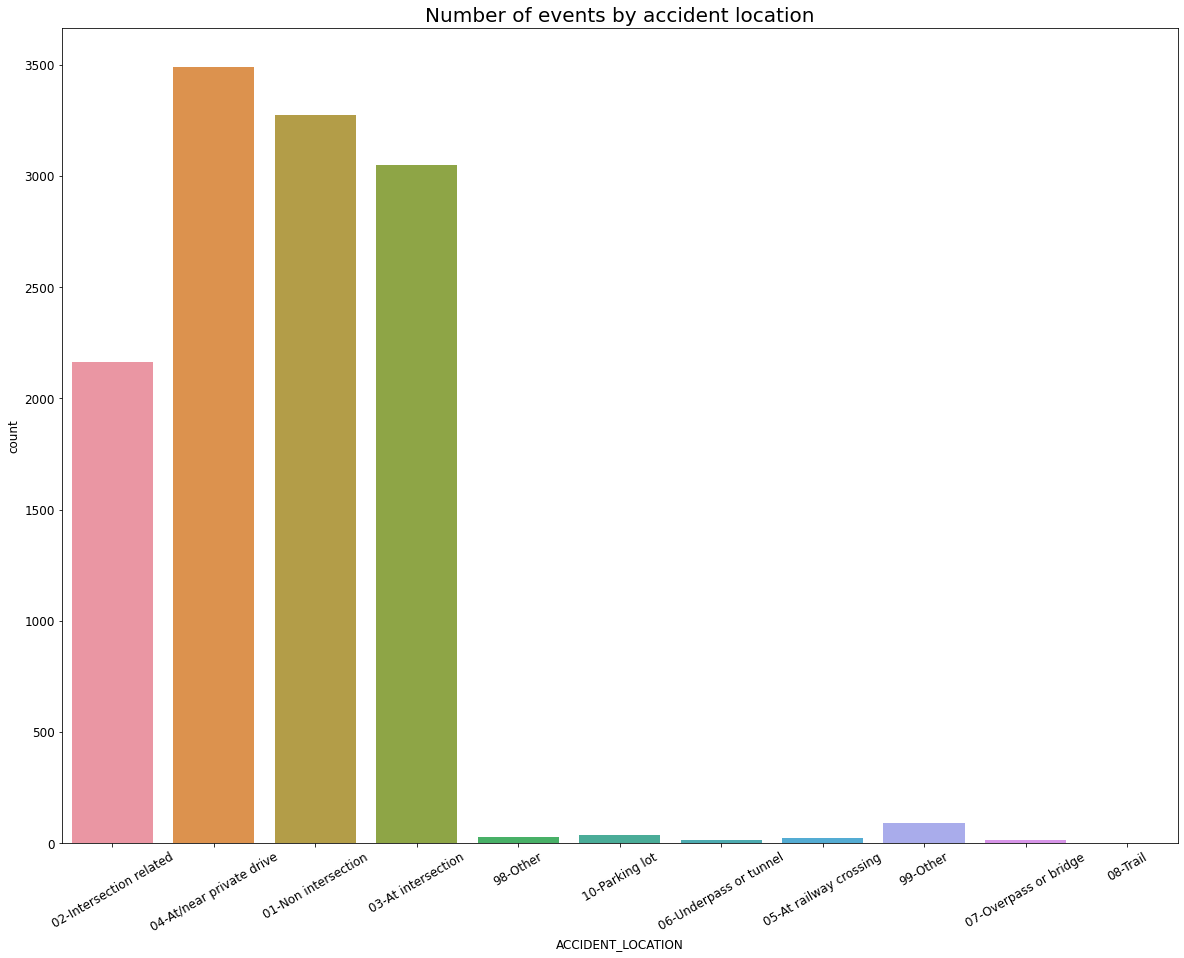

In [6]:
plt.figure(figsize=(20,15))
ax=sns.countplot(TC['ACCIDENT_LOCATION'])
plt.title('Number of events by accident location', size=20)
plt.xticks(rotation=30)
#x_label=['Intersection related', 'At/near private drive','Non intersection', 'At intersection', 'Other2', 'Parking lot', 'nan', 'Underpass or tunnel', 'At railway crossing', 'Other1', 'Overpass or bridge','Trail']
#ax.set(xlabel=x_label)
plt.show()

The most frequent location of accidents was at/near a private drive

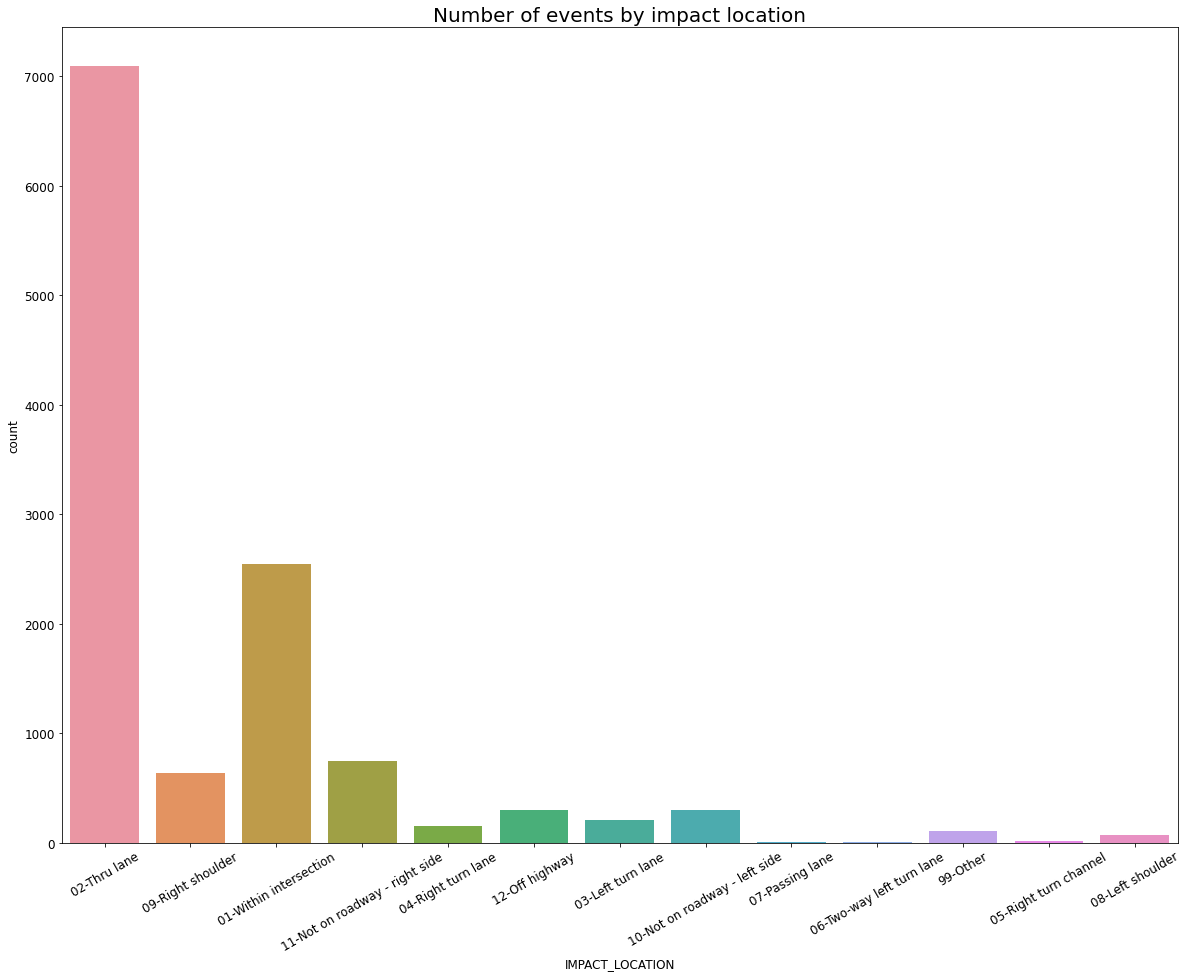

In [7]:
plt.figure(figsize=(20,15))
sns.countplot(TC['IMPACT_LOCATION'])
plt.title('Number of events by impact location', size=20)
plt.xticks(rotation=30)
plt.show()

The most frequent impact location of accidents was through lane.

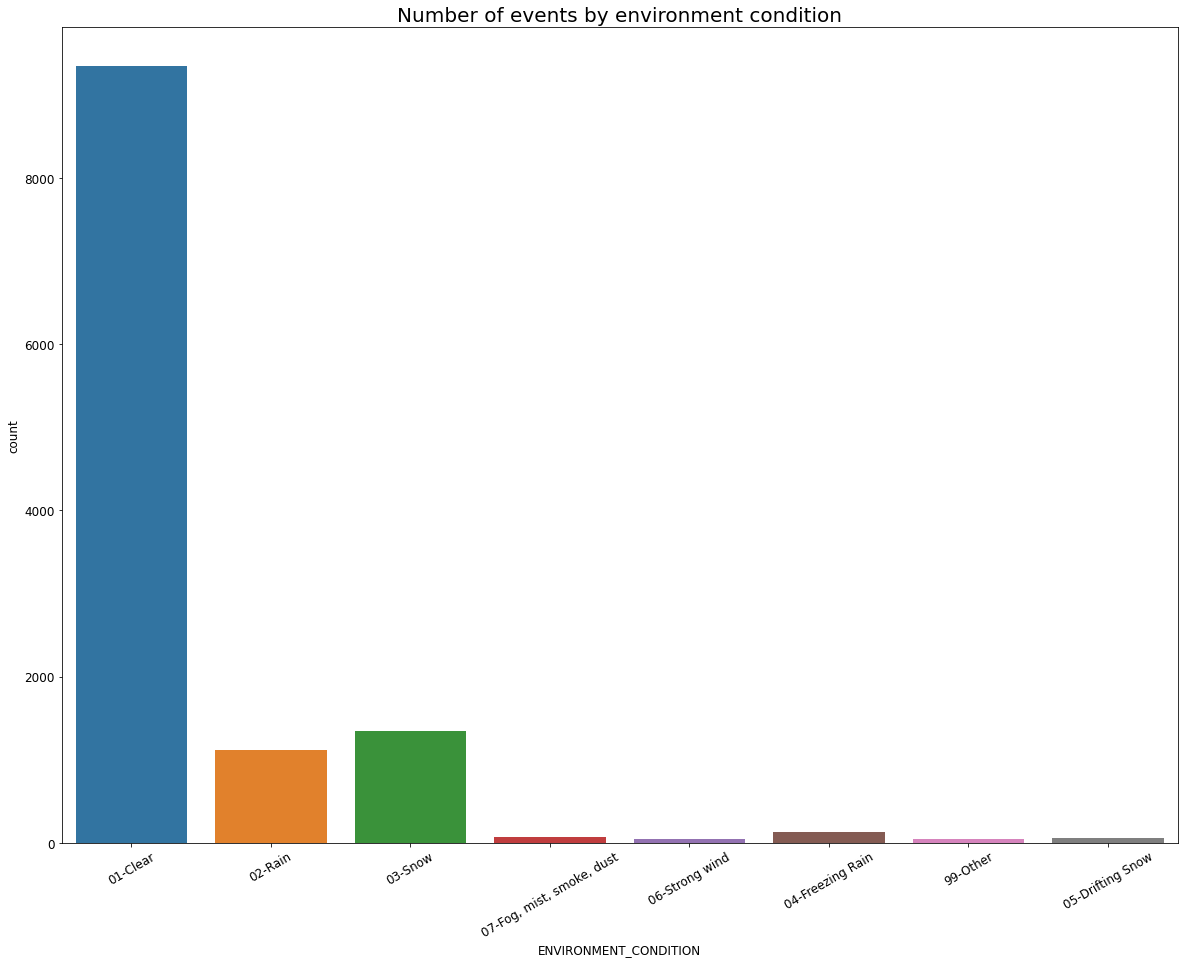

In [8]:
plt.figure(figsize=(20,15))
sns.countplot(TC['ENVIRONMENT_CONDITION'])
plt.title('Number of events by environment condition', size=20)
plt.xticks(rotation=30)
plt.show()

The majority of car crashes happened on a clear day.

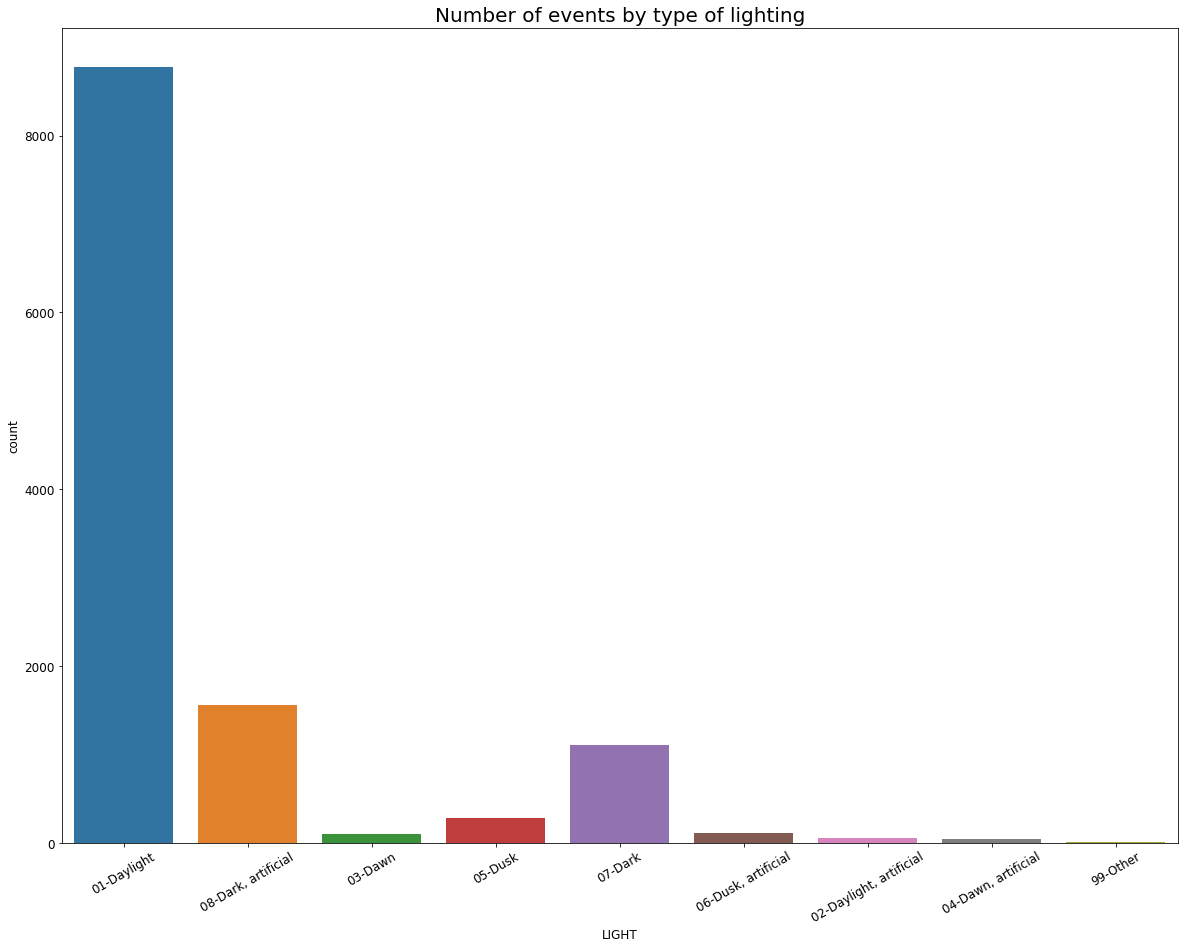

In [9]:
plt.figure(figsize=(20,15))
sns.countplot(TC['LIGHT'])
plt.title('Number of events by type of lighting', size=20)
plt.xticks(rotation=30)
plt.show()

The majority of car crashes happened with an illumination type "daylight".

### Geospatial visualization
We are going to produce a visualization of the car crashes within the city of Kirchner by using their geolocalization. Further one we will build a heat map to see which are the roads where more accidents occur.
<br>

<br>
Dataset with the city of Kitchener divided in wards, we will use it later for a plot

In [10]:
wards= gpd.read_file("Wards.geojson")

Dataset with the roads of Kitchener

In [11]:
roads = gpd.read_file("Roads.geojson")
print(roads.shape)
roads.head()

(5936, 71)


,OBJECTID,ROADSEGMENTID,STREET,FROM_STREET,TO_STREET,FROM_LEFT_ADDRESS,TO_LEFT_ADDRESS,FROM_RIGHT_ADDRESS,TO_RIGHT_ADDRESS,RIGHT_SIDE_PARITY,...,SPEED_LIMIT_KM,TRUCK_ACCESS,BUS_ROUTE,AADT,AADT_YEAR,AADT_TYPE,CALCULATED_MTO_CLASS,SERVICE_YEAR,Shape__Length,geometry
0,52802,23084,FAIRWAY RD N,NORTH HILL PL,OLD CHICOPEE TRAIL,324.0,324.0,NaN,NaN,ODD,...,50,NO ACCESS,N,1000,None,ESTIMATE,5,None,171.547722,"LINESTRING (-80.42746 43.43587, -80.42729 43.4..."
1,52803,22762,BLACK WALNUT DR,CARLYLE DR,BIEHN DR,80.0,80.0,87.0,109.0,ODD,...,50,NO ACCESS,Y,2889,1997,8 HR TMC,5,1976,153.433200,"LINESTRING (-80.45380 43.39280, -80.45402 43.3..."
2,52804,22729,BECHTEL DR,PIONEER DR,DOON VILLAGE RD,15.0,15.0,NaN,NaN,EVEN,...,40,NO ACCESS,Y,2752,2016,24 HR AADT,5,1971,320.105477,"LINESTRING (-80.43759 43.39356, -80.43761 43.3..."
3,52805,21528,ANVIL ST,WHIPPLETREE PL,FARMINGTON PL,77.0,109.0,NaN,NaN,EVEN,...,50,NO ACCESS,N,450,2003,ESTIMATE,5,1980,101.994934,"LINESTRING (-80.44147 43.38953, -80.44188 43.3..."
4,52806,6616,EBY ST S,HALLS LANE E,CHARLES ST E,21.0,25.0,22.0,22.0,EVEN,...,50,NO ACCESS,N,2500,2003,ESTIMATE,5,2005,34.417292,"LINESTRING (-80.48497 43.44735, -80.48520 43.4..."


Let's visualize the roads of Kitchener, emphasizing the type of street.

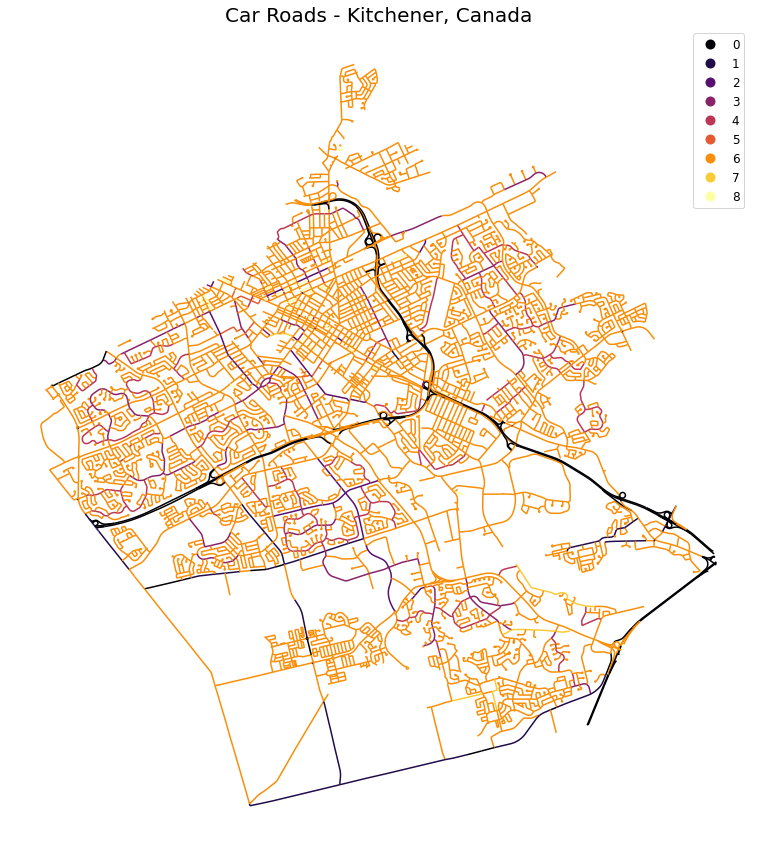

In [12]:
roads.plot(markersize=0.01, column='OFFICIAL_ROAD_CLASSIFICATION',figsize=(20, 15), cmap = 'inferno', legend=True);
plt.axis('off');
plt.title("Car Roads - Kitchener, Canada", size=20);
plt.show()

Let's plot the car crashes in the map of Kitchner

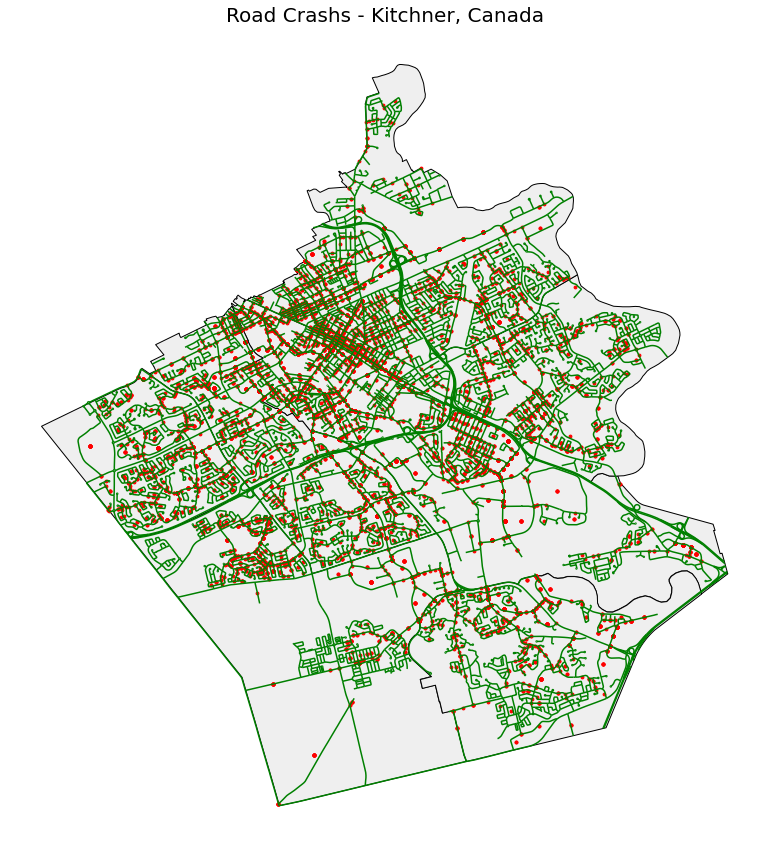

In [13]:
ax = wards.plot(figsize=(20,15), color='#EFEFEF', edgecolor='black')
roads.plot(ax=ax, color='green', markersize=0.2)
TC.plot(ax=ax, color='red', markersize=8) #incidenti
plt.title("Road Crashs - Kitchner, Canada", size=20);
plt.axis('off');

#### Most dangerous areas of the city.

We are going to create a heat map to show in which ward the most number of accidents occurred.

In [14]:
cols = ['ACCIDENTNUM','ACCIDENTDATE', 'LOCATION', 'ACCIDENT_LOCATION', 'IMPACT_LOCATION', 'ENVIRONMENT_CONDITION', 'LIGHT', 'COLLISION_TYPE', 'COLLISION_TYPE', 'TRAFFICCOLLISIONSID']
crashes = TC.drop(cols, axis=1)
crashes['ward']=''

for j in range(len(wards)):
    for i in range(1,len(crashes)+1):
        if crashes.loc[i, 'geometry'].within(wards.geometry[j]):
            crashes.loc[i,'ward']=wards.geometry.index[j]

crashes['crashes']=''
for j in range(len(wards)):
    wards.loc[j, 'crashes']=crashes.ward.value_counts()[j]

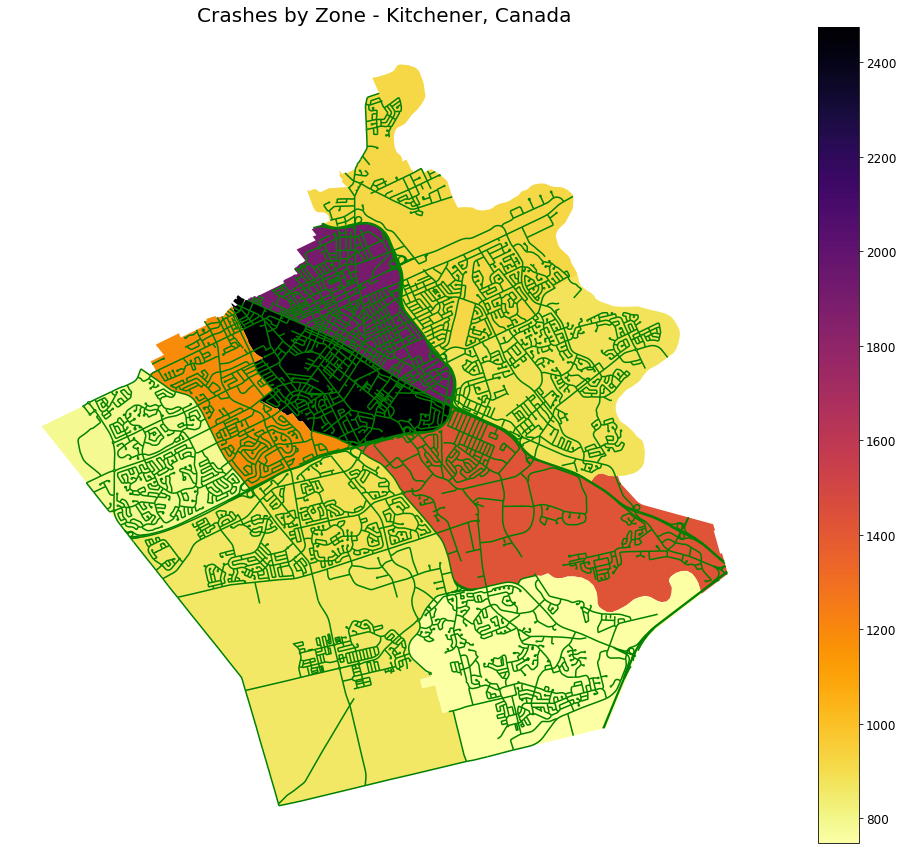

In [15]:
ax = wards.plot(figsize=(20,15), column='crashes', cmap='inferno_r', k=5, legend=True)
roads.plot(ax=ax, color = 'green')
plt.title("Crashes by Zone - Kitchener, Canada", size=20);
ax.set_axis_off()

Looking at the last visualization, we can see that for example, areas with a higher density of streets, are more prone to have accidents.

#### Most dangerous roads of the city.

Now, let's associate at each road the number of accidents that occurred on that road. Consequently, we will build another heat map, to visualize the most dangerous roads.

For each road linear segment, we will collect the crashes that happened at a given distance from it, for example, 10m. For that, the GeoPandas function buffer will be used. Note that a single event could be captured in more than one road, on intersections, for example. But we are assuming that this should be important, once all segments are impacted.

In [16]:
meters = 10
buffer = (meters*0.1)/11000  # degrees
crashes['crashes'] = 1
crashes = crashes[['geometry', 'crashes']].copy()
crashes['geometry'] = crashes['geometry'].buffer(buffer)

Next, we need spatial-join roads and buffered crash points

In [17]:
roads2=roads[['ROADSEGMENTID', 'geometry']]

In [18]:
f = gpd.sjoin(roads2, crashes, how='inner', op='intersects')

Below we can inspect the resultant geodataframe. Note that lineString is a segment of road that has a single crash event captured. For example, the 3 first lines are the same segment of a street with index 5417, where 3 accidents occurred.

In [19]:
f.head()

,ROADSEGMENTID,geometry,index_right,crashes
1,22762,"LINESTRING (-80.45380 43.39280, -80.45402 43.3...",3536,1
861,25561,"LINESTRING (-80.45558 43.39322, -80.45592 43.3...",3536,1
5148,21775,"LINESTRING (-80.45543 43.39413, -80.45543 43.3...",3536,1
1,22762,"LINESTRING (-80.45380 43.39280, -80.45402 43.3...",5418,1
861,25561,"LINESTRING (-80.45558 43.39322, -80.45592 43.3...",5418,1


Now will be important to group the geodataframe, by ROADSEGMENTID. Doing that, we will have the segments aggregating the crashes. 

In [20]:
g = f.groupby('ROADSEGMENTID', as_index=False).agg({
  'crashes': 'sum', 
  'geometry': 'first',
  })
g = gpd.GeoDataFrame(g)
g.head()

,ROADSEGMENTID,crashes,geometry
0,1223,5,"LINESTRING (-80.51861 43.44230, -80.51802 43.4..."
1,1224,10,"LINESTRING (-80.51233 43.44394, -80.51494 43.4..."
2,1226,4,"LINESTRING (-80.51610 43.44358, -80.51659 43.4..."
3,1227,16,"LINESTRING (-80.51302 43.44078, -80.51462 43.4..."
4,1229,7,"LINESTRING (-80.51797 43.44356, -80.51945 43.4..."


Assign to the roads with no accidents the label "0 crashes"

In [21]:
roads2['crashes']=0

for i in range(len(roads)):
    for j in range(len(g)):
        if roads2.loc[i, 'ROADSEGMENTID']== g.loc[j, 'ROADSEGMENTID']:
            roads2.loc[i, 'crashes']=g.loc[j, 'crashes']

Let’s visualize all streets, having a color associated with each road segment (Heat map)

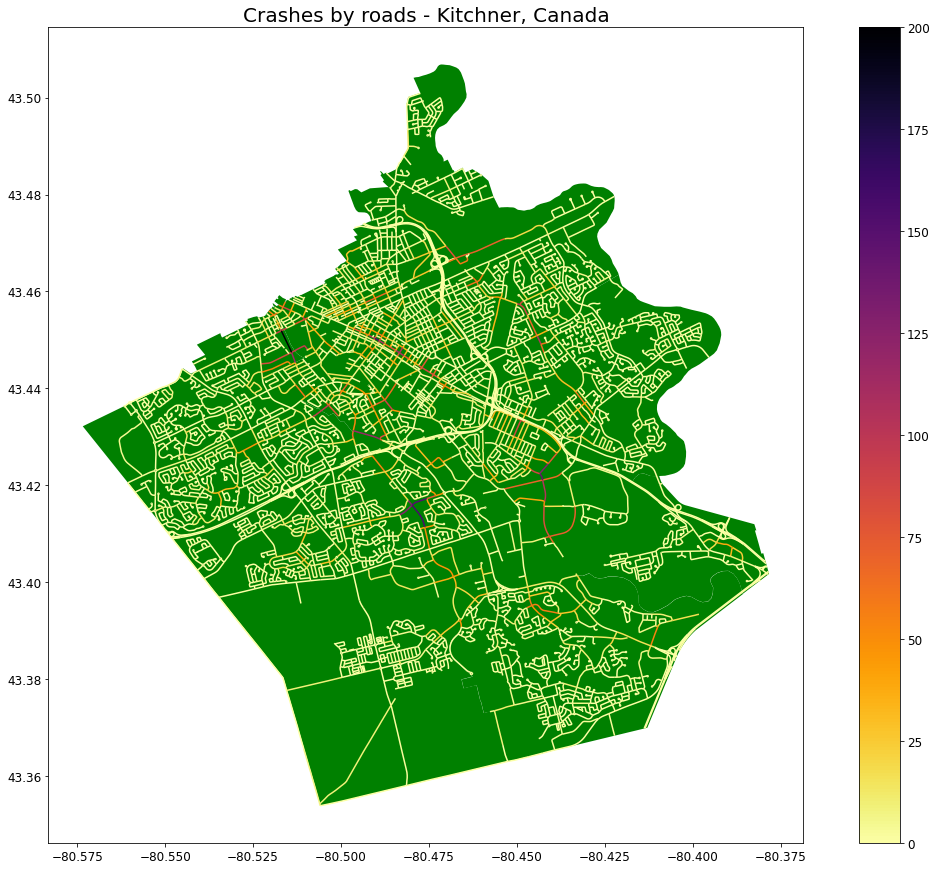

In [22]:
fig, ax = plt.subplots(figsize = (20,15)) 
wards.plot(ax=ax, color='green')#, edgecolor='black')
roads2.plot(ax=ax, column='crashes', cmap='inferno_r', k=5, legend=True)
plt.title('Crashes by roads - Kitchner, Canada', size=20);

After having explored our datasets, we are going to build the predictive model of traffic accidents at street level with Machine Learning tecniques.
descrizione procedura
First, we will merge the collisions dataset and roads dataset then we will process it in order to generate the new data.
lavoro su new data
creation on model


### Data preprocessing 
We are going to transform the data we have, to build the final model.

#### Merge of collisions dataset and roads dataset
We want to associate at every accidents the characteristics of the road in which it occurs

 Processing the dates

In [23]:
TC['ACCIDENTDATE_YEAR']=[int(x[:4]) for x in TC['ACCIDENTDATE']]
TC['ACCIDENTDATE_MONTH']=[(x[4:6]) for x in TC['ACCIDENTDATE']]
TC['ACCIDENTDATE_DAY']=[(x[6:]) for x in TC['ACCIDENTDATE']]

from datetime import datetime
TC['ACCIDENTDATE_datetime']=[datetime.strptime(x, "%Y%m%d") for x in TC['ACCIDENTDATE']]
del TC['ACCIDENTDATE']

Preprocess location

In [24]:
# l1 @ l2 --> intersection beetwenn l1 and l2
# l1 btwn l2/l3 --> collision in l1 from l2 to l3

# split the locations

import re
TC['LOCATION_LIST']=[re.split(' @ | & | btwn | /', x) for x in TC['LOCATION']] 
TC['LOCATION_1']=[x[0] for x in TC['LOCATION_LIST']]
TC['LOCATION_2']=[x[1] for x in TC['LOCATION_LIST']]
TC['LOCATION_3']=[x[-1] for x in TC['LOCATION_LIST']]
TC_2=TC.copy()
TC.head()

,ACCIDENTNUM,LOCATION,ACCIDENT_LOCATION,IMPACT_LOCATION,ENVIRONMENT_CONDITION,LIGHT,COLLISION_TYPE,TRAFFICCOLLISIONSID,geometry,ACCIDENTDATE_YEAR,ACCIDENTDATE_MONTH,ACCIDENTDATE_DAY,ACCIDENTDATE_datetime,LOCATION_LIST,LOCATION_1,LOCATION_2,LOCATION_3
OBJECTID,,,,,,,,,,,,,,,,,
1,13-118637,CEDAR ST N @ KING ST E / CEDAR ST S,02-Intersection related,02-Thru lane,01-Clear,01-Daylight,INTERSECTION,None,MULTIPOINT (-80.48344 43.44734),2013,05,25,2013-05-25,"[CEDAR ST N, KING ST E, CEDAR ST S]",CEDAR ST N,KING ST E,CEDAR ST S
2,13-019811,GLASGOW ST @ BELMONT AVE W,04-At/near private drive,02-Thru lane,01-Clear,01-Daylight,INTERSECTION,None,MULTIPOINT (-80.51699 43.45189),2013,01,24,2013-01-24,"[GLASGOW ST, BELMONT AVE W]",GLASGOW ST,BELMONT AVE W,BELMONT AVE W
3,12-089689,CEDAR ST N @ KING ST E / CEDAR ST S,01-Non intersection,09-Right shoulder,01-Clear,01-Daylight,INTERSECTION,None,MULTIPOINT (-80.48344 43.44734),2012,04,18,2012-04-18,"[CEDAR ST N, KING ST E, CEDAR ST S]",CEDAR ST N,KING ST E,CEDAR ST S
4,12-127500,BELMONT AVE W @ ARGYLE ST,03-At intersection,01-Within intersection,02-Rain,01-Daylight,INTERSECTION,None,MULTIPOINT (-80.51844 43.45418),2012,06,01,2012-06-01,"[BELMONT AVE W, ARGYLE ST]",BELMONT AVE W,ARGYLE ST,ARGYLE ST
5,13-012564,STRASBURG RD @ HURON RD,03-At intersection,01-Within intersection,01-Clear,"08-Dark, artificial",INTERSECTION,None,MULTIPOINT (-80.46622 43.39197),2013,01,15,2013-01-15,"[STRASBURG RD, HURON RD]",STRASBURG RD,HURON RD,HURON RD


In [25]:
R = roads
pd.set_option('display.max_columns', None)
R.head()

,OBJECTID,ROADSEGMENTID,STREET,FROM_STREET,TO_STREET,FROM_LEFT_ADDRESS,TO_LEFT_ADDRESS,FROM_RIGHT_ADDRESS,TO_RIGHT_ADDRESS,RIGHT_SIDE_PARITY,REGIONAL_ROAD,HIGHWAY,MUNICIPALITY,GENERAL_GRID_ID,LANES,SEQUENCE,STATUS_DATE,OWNERSHIP,PLOW_ROUTE,MEDIAN_TYPE,STREET_NAME,STREET_TYPE,STREET_DIRECTION,PLOW_PRIORITY,LEAF_ROUTE,CREATE_DATE,LEFT_MUNICIPALITY,RIGHT_MUNICIPALITY,CREATE_BY,UPDATE_DATE,UPDATE_BY,SOURCE_DATE,SOURCE,REVISION_NOTES,CATEGORY,SUBCATEGORY,STATUS,PAVEMENT_WIDTH,ROW_WIDTH,QUARTER_GRID_ID,WARDID,PLANNINGCOMMUNITYID,STR_ROADSEGMENTID,FIRERESPONSEZONEID,PARCELID,SHOULDER,MAINTENANCE,FLOW_DIRECTION,CARTO_CLASS,OPERATIONS_CLASS,SALT_SAND_ROUTE,STARTX,STARTY,ENDX,ENDY,ROAD_PATROL,OPERATIONS_MTO_CLASS,LAST_ROAD_PATROL_DATE,NEXT_ROAD_PATROL_DUE,SURFACE_LAYER_TYPE,OFFICIAL_ROAD_CLASSIFICATION,SPEED_LIMIT_KM,TRUCK_ACCESS,BUS_ROUTE,AADT,AADT_YEAR,AADT_TYPE,CALCULATED_MTO_CLASS,SERVICE_YEAR,Shape__Length,geometry
0,52802,23084,FAIRWAY RD N,NORTH HILL PL,OLD CHICOPEE TRAIL,324.0,324.0,NaN,NaN,ODD,REGIONAL RD 53,None,KITCHENER,434,4,7.0,1998-07-24T16:26:59+00:00,REG,17-1,NO,FAIRWAY,RD,N,1.0,X,2000-01-01T00:00:00+00:00,KITCHENER,KITCHENER,BERTHAF,2021-04-23T08:36:08+00:00,GIS_DATA,2003-05-30T00:00:00+00:00,REG PLAN 1664,test,ROAD,MAJOR,ACTIVE,15.0,51.0,434-A,2,35,23084,80,55074657,PAVED,YEAR ROUND,TwoWay,Arterial,CITY,9,546336.1284,4.809377e+06,546462.2121,4.809492e+06,Y,3,2021-04-23T08:20:51+00:00,2021-04-30T08:20:51+00:00,PAVED,6,50,NO ACCESS,N,1000,None,ESTIMATE,5,None,171.547722,"LINESTRING (-80.42746 43.43587, -80.42729 43.4..."
1,52803,22762,BLACK WALNUT DR,CARLYLE DR,BIEHN DR,80.0,80.0,87.0,109.0,ODD,None,None,KITCHENER,515,2,3.0,1998-07-20T09:43:18+00:00,KIT,15-1,NO,BLACK WALNUT,DR,None,2.0,X,2000-01-01T00:00:00+00:00,KITCHENER,KITCHENER,BERTHAF,2021-04-21T08:05:51+00:00,GIS_DATA,1970-01-01T00:00:00+00:00,None,None,ROAD,MINOR,ACTIVE,10.0,26.0,515-D,4,42,22762,118,55070919,PAVED,YEAR ROUND,TwoWay,Collector,CITY,15,544235.5700,4.804580e+06,544091.1300,4.804625e+06,Y,4,2021-04-21T07:54:34+00:00,2021-05-05T07:54:34+00:00,PAVED,4,50,NO ACCESS,Y,2889,1997,8 HR TMC,5,1976,153.433200,"LINESTRING (-80.45380 43.39280, -80.45402 43.3..."
2,52804,22729,BECHTEL DR,PIONEER DR,DOON VILLAGE RD,15.0,15.0,NaN,NaN,EVEN,None,None,KITCHENER,515,2,1.0,1998-07-20T16:19:51+00:00,KIT,16-1,NO,BECHTEL,DR,None,2.0,X,2000-01-01T00:00:00+00:00,KITCHENER,KITCHENER,BERTHAF,2021-04-21T08:05:50+00:00,GIS_DATA,1970-01-01T00:00:00+00:00,None,None,ROAD,MINOR,ACTIVE,10.0,26.0,515-C,4,42,22729,118,55074034,PAVED,YEAR ROUND,TwoWay,Collector,CITY,15,545547.7400,4.804673e+06,545315.6200,4.804469e+06,Y,5,2021-04-21T07:50:23+00:00,2021-05-21T07:50:23+00:00,PAVED,4,40,NO ACCESS,Y,2752,2016,24 HR AADT,5,1971,320.105477,"LINESTRING (-80.43759 43.39356, -80.43761 43.3..."
3,52805,21528,ANVIL ST,WHIPPLETREE PL,FARMINGTON PL,77.0,109.0,NaN,NaN,EVEN,None,None,KITCHENER,538,2,3.0,1998-07-20T14:59:09+00:00,KIT,15-1,NO,ANVIL,ST,None,3.0,X,2000-01-01T00:00:00+00:00,KITCHENER,KITCHENER,BERTHAF,2021-04-08T10:20:33+00:00,GIS_DATA,1970-01-01T00:00:00+00:00,None,None,ROAD,LOCAL,ACTIVE,9.0,20.0,538-B,4,42,21528,118,55072037,PAVED,YEAR ROUND,TwoWay,Local Street,CITY,0,545236.8599,4.804223e+06,545138.3600,4.804207e+06,Y,5,2021-04-08T10:18:47+00:00,2021-05-08T10:18:47+00:00,PAVED,6,50,NO ACCESS,N,450,2003,ESTIMATE,5,1980,101.994934,"LINESTRING (-80.44147 43.38953, -80.44188 43.3..."
4,52806,6616,EBY ST S,HALLS LANE E,CHARLES ST E,21.0,25.0,22.0,22.0,EVEN,None,None,KITCHENER,411,2,2.0,1998-06-16T11:05:07+00:00,KIT,6-1,NO,EBY,ST,S,2.0,X,2000-01-01T00:00:00+00:00,KITCHENER,KITCHENER,BERTHAF,2021-04-22T08:35:49+00:00,GIS_DATA,2003-04-22T00:00:00+00:00,REG PLAN 367,None,ROAD,LOCAL,ACTIVE,7.0,12.0,411-A,9,1,6616,27,55074052,PAVED,YEAR ROUND,TwoWay,Local Street,CITY,6,541673.3900,4.810622e+06,541655.3862,4.810593e+06,Y,5,2021-04-22T08:27:20+00:00,2021-05-22T08:27:20+00:00,PAVED,6,50,NO ACCESS,N,2500,2003,ESTIMATE,5,2005,34.417292,"LINESTRING (-80.48497 43.44735, -80.48520 43.4..."


Merging TC and R

In [26]:
TC['LOCATION_2'].loc[2756]='SASSAFRAS ST'
TC['LOCATION_3'].loc[2756]='SASSAFRAS ST'
R['FROM_STREET'].loc[1692]='HARVEST CRT'
R['FROM_STREET'].loc[4927]='CATALINA CRT'
l=['ROADSEGMENTID','REGIONAL_ROAD','HIGHWAY','LANES','OWNERSHIP','MEDIAN_TYPE',
'STREET_TYPE','STREET_DIRECTION','PLOW_PRIORITY','CATEGORY','SUBCATEGORY','STATUS',
'PAVEMENT_WIDTH','ROW_WIDTH','FLOW_DIRECTION','CARTO_CLASS','CARTO_CLASS','OPERATIONS_MTO_CLASS',
 'SURFACE_LAYER_TYPE','SPEED_LIMIT_KM','TRUCK_ACCESS','BUS_ROUTE','AADT',
'AADT_TYPE','Shape__Length']   
d={}
for i in TC.index:
    dTC=TC.loc[i].to_dict()
    if dTC['LOCATION_1']=='COUNTRYSTONE CRES' and dTC['LOCATION_2']=='GARDEN PATH PL':
        dTC['LOCATION_2']='SASSAFRAS ST' 
    if dTC['LOCATION_1']=='KING ST E' and dTC['LOCATION_2']=='QUEEN ST N':
        dTC['LOCATION_2']='QUEEN ST S'
    elif dTC['LOCATION_1']=='HURON RD' and dTC['LOCATION_2']=='PLAINS RD':
        dTC['LOCATION_2']='FISCHER HALLMAN RD' 
    elif dTC['LOCATION_1']=='DONNENWERTH DR' and dTC['LOCATION_2']=='COPPER LEAF CRES':
        dTC['LOCATION_2']='PERIWINKLE ST'
    elif dTC['LOCATION_1']=='EAST AVE' and dTC['LOCATION_2']=='SHERBOURNE AVE':
        dTC['LOCATION_2']='EUGENE GEORGE WAY'
    elif dTC['LOCATION_1']=='PARK ST' and dTC['LOCATION_2']=='AGNES ST':
        dTC['LOCATION_2']='DOMINION ST'
    elif dTC['LOCATION_1']=='QUEEN ST S' and dTC['LOCATION_2']=='COURTLAND AVE W':
        dTC['LOCATION_2']='COURTLAND AVE E'
        print('ok')
    elif dTC['LOCATION_1']=='WELLINGTON ST N' and dTC['LOCATION_2']=='WELLINGTON ST N':
        dTC['LOCATION_2']='LANCASTER ST W'
    elif dTC['LOCATION_1']=='BURGETZ AVE' and dTC['LOCATION_2']=='KINZIE AVE':
        dTC['LOCATION_2']='GRULKE ST'
    if '/' in dTC['LOCATION_2']:
        l2=dTC['LOCATION_2'].split(' / ')
        l3=[dTC['LOCATION_1']]+l2
        dTC['LOCATION_LIST']=str(l3)
        dTC['LOCATION_2']=l2[0]
        dTC['LOCATION_3']=l2[1]
    if len(dTC['LOCATION_LIST'])==2:
        dR=R[l].loc[R[((R['STREET']==dTC['LOCATION_1']) & ((R['FROM_STREET']==dTC['LOCATION_2'])|(R['TO_STREET']==dTC['LOCATION_2'])))|
                     ((R['STREET']==dTC['LOCATION_2']) & ((R['FROM_STREET']==dTC['LOCATION_1'])|(R['TO_STREET']==dTC['LOCATION_1'])))].sort_values(by=['AADT']).index[0]].to_dict()
                    
    elif len(dTC['LOCATION_LIST'])==3:
        try:
            dR=R[l].loc[R[((R['STREET']==dTC['LOCATION_1']) & ((R['FROM_STREET']==dTC['LOCATION_2'])|(R['TO_STREET']==dTC['LOCATION_3'])))|
                     ((R['STREET']==dTC['LOCATION_1']) & ((R['FROM_STREET']==dTC['LOCATION_3'])|(R['TO_STREET']==dTC['LOCATION_2'])))].sort_values(by=['AADT']).index[0]].to_dict()
        except IndexError:
            pass
    d[i]=dR.copy()   

In [27]:
R_mer=pd.DataFrame(d).T

In [28]:
TC_R=TC.merge(R_mer, left_index=True, right_index=True)

In [29]:
TC_R.to_csv('Traffic_Collisions_Geometry_Road.csv')

#### First cleaning and preprocessing of unified dataset (Traffic collisions + Roads)


In [30]:
TC=pd.read_csv('Traffic_Collisions_Geometry_Road.csv', index_col = 0)

In [31]:
col = ['ACCIDENTNUM',
       'LOCATION',
       'ACCIDENT_LOCATION',
       'IMPACT_LOCATION',
       'COLLISION_TYPE',
       'LIGHT',
       'TRAFFICCOLLISIONSID',
       'ACCIDENTDATE_DAY',
       'ACCIDENTDATE_datetime',
       'LOCATION_LIST',
       'LOCATION_2', 
       'LOCATION_3',
       'GEOMETRY',
       'REGIONAL_ROAD', 
       'HIGHWAY',
       'OWNERSHIP',
       'MEDIAN_TYPE',
       'STREET_DIRECTION', 
       'PLOW_PRIORITY',
       'STATUS',
       'OPERATIONS_MTO_CLASS',
       'AADT_TYPE', 
       'Shape__Length',
       'CATEGORY',
       'SUBCATEGORY',
       'STREET_TYPE'
]

TC = TC.drop(columns = col)

In [32]:
TC.head()

,ENVIRONMENT_CONDITION,ACCIDENTDATE_YEAR,ACCIDENTDATE_MONTH,LOCATION_1,ROADSEGMENTID,LANES,PAVEMENT_WIDTH,ROW_WIDTH,FLOW_DIRECTION,CARTO_CLASS,SURFACE_LAYER_TYPE,SPEED_LIMIT_KM,TRUCK_ACCESS,BUS_ROUTE,AADT
1,01-Clear,2013,5,CEDAR ST N,6621,2,9.0,16.0,TwoWay,Collector,PAVED,50,NO ACCESS,N,1000
2,01-Clear,2013,1,GLASGOW ST,1252,2,11.0,22.0,TwoWay,Collector,PAVED,50,NO ACCESS,N,1000
3,01-Clear,2012,4,CEDAR ST N,6621,2,9.0,16.0,TwoWay,Collector,PAVED,50,NO ACCESS,N,1000
4,02-Rain,2012,6,BELMONT AVE W,1356,2,7.0,20.0,TwoWay,Local Street,PAVED,50,NO ACCESS,N,450
5,01-Clear,2013,1,STRASBURG RD,103097,1,10.0,28.0,ToFrom,Roundabout,PAVED,50,NO ACCESS,N,1000


In [33]:
# FLOW_DIRECTION    
TC['TWO_WAY'] = TC['FLOW_DIRECTION'].apply(lambda x: int(x=='TwoWay'))
TC = TC.drop(columns= ['FLOW_DIRECTION'])

In [34]:
# SURFACE_LAYER_TYPE    
TC['PAVED'] = TC['SURFACE_LAYER_TYPE'].apply(lambda x: int(x=='PAVED'))
TC = TC.drop(columns= ['SURFACE_LAYER_TYPE'])

In [35]:
# TRUCK_ACCESS 
TC['TRUCK_ACCESS'] = TC['TRUCK_ACCESS'].apply(lambda x: int(x!='NO ACCESS'))

In [36]:
# BUS_ROUTE
TC['BUS_ROUTE'] = TC['BUS_ROUTE'].apply(lambda x: int(x=='Y'))

In [37]:
# CARTO_CLASS -----> STREET TYPE
for t in TC['CARTO_CLASS'].unique():
    TC[t] = np.zeros(len(TC))
    TC[t] = TC['CARTO_CLASS'].apply(lambda x: int(x == t))
    
TC = TC.drop(columns=['CARTO_CLASS'])
TC = TC.rename(columns={'LOCATION_1':'street'})
TC = TC.rename(columns={'ACCIDENTDATE_MONTH':'month'})

In [38]:
TC.head()

,ENVIRONMENT_CONDITION,ACCIDENTDATE_YEAR,month,street,ROADSEGMENTID,LANES,PAVEMENT_WIDTH,ROW_WIDTH,SPEED_LIMIT_KM,TRUCK_ACCESS,BUS_ROUTE,AADT,TWO_WAY,PAVED,Collector,Local Street,Roundabout,Arterial,Alleyway / Lane,Expressway / Highway,Cul-de-Sac
1,01-Clear,2013,5,CEDAR ST N,6621,2,9.0,16.0,50,0,0,1000,1,1,1,0,0,0,0,0,0
2,01-Clear,2013,1,GLASGOW ST,1252,2,11.0,22.0,50,0,0,1000,1,1,1,0,0,0,0,0,0
3,01-Clear,2012,4,CEDAR ST N,6621,2,9.0,16.0,50,0,0,1000,1,1,1,0,0,0,0,0,0
4,02-Rain,2012,6,BELMONT AVE W,1356,2,7.0,20.0,50,0,0,450,1,1,0,1,0,0,0,0,0
5,01-Clear,2013,1,STRASBURG RD,103097,1,10.0,28.0,50,0,0,1000,0,1,0,0,1,0,0,0,0


In [39]:
TC = TC[(TC['ENVIRONMENT_CONDITION'] == '01-Clear') | 
        (TC['ENVIRONMENT_CONDITION'] == '02-Rain') | 
        (TC['ENVIRONMENT_CONDITION'] == '03-Snow') | 
        (TC['ENVIRONMENT_CONDITION'] == '05-Drifting Snow') | 
        (TC['ENVIRONMENT_CONDITION'] == '04-Freezing Rain')]

In [40]:
# ENVIRONMENT_CONDITION

TC['CLEAR'] = TC['ENVIRONMENT_CONDITION'].apply(lambda x: int(x == '01-Clear'))
TC['RAIN'] = TC['ENVIRONMENT_CONDITION'].apply(lambda x: int(x in ['02-Rain','04-Freezing Rain']))
TC['SNOW'] = TC['ENVIRONMENT_CONDITION'].apply(lambda x: int(x in ['03-Snow', '05-Drifting Snow']))

TC = TC.drop(columns=['ENVIRONMENT_CONDITION'])

In [41]:
TC.to_csv('collisions.csv', index = False)

Cleaned and Processed of unified dataset

In [42]:
TC.head()

,ACCIDENTDATE_YEAR,month,street,ROADSEGMENTID,LANES,PAVEMENT_WIDTH,ROW_WIDTH,SPEED_LIMIT_KM,TRUCK_ACCESS,BUS_ROUTE,AADT,TWO_WAY,PAVED,Collector,Local Street,Roundabout,Arterial,Alleyway / Lane,Expressway / Highway,Cul-de-Sac,CLEAR,RAIN,SNOW
1,2013,5,CEDAR ST N,6621,2,9.0,16.0,50,0,0,1000,1,1,1,0,0,0,0,0,0,1,0,0
2,2013,1,GLASGOW ST,1252,2,11.0,22.0,50,0,0,1000,1,1,1,0,0,0,0,0,0,1,0,0
3,2012,4,CEDAR ST N,6621,2,9.0,16.0,50,0,0,1000,1,1,1,0,0,0,0,0,0,1,0,0
4,2012,6,BELMONT AVE W,1356,2,7.0,20.0,50,0,0,450,1,1,0,1,0,0,0,0,0,0,1,0
5,2013,1,STRASBURG RD,103097,1,10.0,28.0,50,0,0,1000,0,1,0,0,1,0,0,0,0,1,0,0


#### GENERATE RANDOM INSTANCES
We are going to transform the data we have, we had a dataset composed of accidents, to build a predictive model of car crashes, we had to generate some non-accidents instances. 
The procedure of generation:
* We obtained from the roads dataset the probability distribution of traffic within Kitchener, to get the busiest streets (in percentage). From this distribution, we generated cars moving in the streets (that can have or not an accident).
* We generated the distribution probability collisions per average month.
* We obtained the probability distribution of the weather (clear, rain, snow) for every month, for every year.  <br>
Every new instance is a road with weather and in which happen or not an accident according to the previous distributions.  to build the final model.

 Probability of collisions per average month per year

In [45]:
prob_coll_per_street_year = dict()

for y in sorted(list(TC['ACCIDENTDATE_YEAR'].unique())):
    TC_y = TC[TC['ACCIDENTDATE_YEAR'] == y]    
    X = TC_y.street.value_counts() / 12   
    for s in X.index:
        X[s] = X[s]/ (TC_y[TC_y['street'] == s]['AADT'].mean()*30)
    prob_coll_per_street_year[y] = dict(X)
    
prob_coll_street_y = pd.DataFrame(prob_coll_per_street_year)
prob_coll_street_y = prob_coll_street_y.fillna(0)
prob_coll_street_y.head()
prob_coll_street_y.to_csv('prob_coll.csv')

The probability that a car is moving in a street

In [46]:
# PROB CAR IN STREET

prob_car_in_street = dict()

for y in sorted(list(TC['ACCIDENTDATE_YEAR'].unique())):
    X = R.groupby('STREET')['AADT'].mean() / R.groupby('STREET')['AADT'].mean().sum()
    prob_car_in_street[y] = dict(X)

prob_car_in_street_y = pd.DataFrame(prob_car_in_street)
prob_car_in_street_y = prob_car_in_street_y.fillna(0)

prob_car_in_street = pd.DataFrame(X.values, columns=['prob_car_in_street'], index = X.index)
prob_car_in_street.to_csv('prob_car_in_street.csv')

Number of collisions per year per month

In [48]:
TC_2 = pd.read_csv('collisions.csv')

for i in range(len(TC_2)):
    TC_2.loc[i,'YEAR_MONTH']=str(TC_2.loc[i,'ACCIDENTDATE_YEAR'])+str(TC_2.loc[i,'month'])

In [50]:
TC_2 = pd.read_csv('collisions.csv')

for i in range(len(TC_2)):
    TC_2.loc[i,'YEAR_MONTH']=str(TC_2.loc[i,'ACCIDENTDATE_YEAR'])+str(TC_2.loc[i,'month'])

# N_COLL_PER_YM
d = dict()
for y in sorted(list(TC_2['YEAR_MONTH'].unique())):
    TC_y = TC_2[TC_2['YEAR_MONTH'] == y]
    d[y] = TC_y['street'].value_counts()

df = pd.DataFrame(d).fillna(0)
df.to_csv('n_coll_per_ym.csv')

The probability that in a specific month of a specific year is clear, or raining, or snowing

In [54]:
#dataset with weather of Kitchener from 2015 to 2018
weather=pd.concat([pd.read_csv('en_climate_daily_ON_6147188_2005_P1D.csv'), 
                pd.read_csv('en_climate_daily_ON_6147188_2006_P1D.csv'), 
                pd.read_csv('en_climate_daily_ON_6147188_2007_P1D.csv'),
                pd.read_csv('en_climate_daily_ON_6147188_2008_P1D.csv'),
                pd.read_csv('en_climate_daily_ON_6147188_2009_P1D.csv'),
                pd.read_csv('en_climate_daily_ON_6147188_2010_P1D.csv'),
                pd.read_csv('en_climate_daily_ON_6147188_2011_P1D.csv'),
                pd.read_csv('en_climate_daily_ON_6147188_2012_P1D.csv'),
                pd.read_csv('en_climate_daily_ON_6147188_2013_P1D.csv'),
                pd.read_csv('en_climate_daily_ON_6147188_2014_P1D.csv'),
                pd.read_csv('en_climate_daily_ON_6147188_2015_P1D.csv'),
                pd.read_csv('en_climate_daily_ON_6147188_2016_P1D.csv'),
                pd.read_csv('en_climate_daily_ON_6147188_2017_P1D.csv'),
                pd.read_csv('en_climate_daily_ON_6147188_2018_P1D.csv')
                ])

weather.index=range(len(weather))

weather=weather[['Year', 'Month','Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)']]

for i in range(len(weather)):
    if weather.loc[i,'Month']<10:
        weather.loc[i,'M-Y']='0'+str(weather.loc[i,'Month'])+'-'+str(weather.loc[i,'Year'])
    else:
        weather.loc[i,'M-Y']=str(weather.loc[i,'Month'])+'-'+str(weather.loc[i,'Year'])
        
weather=weather[['M-Y','Year', 'Month','Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)']]
weather.dropna(inplace=True)

clear=[]
rain=[]
snow=[]
for year in range(2005, 2018):
    for month in range(1, 13):
        mask=(weather.Year==year) & (weather.Month==month)
        df2=weather[mask]
        
        num_days=len(df2)
        pioggia=len(df2[df2['Total Rain (mm)']!=0.0])/num_days
        neve=len(df2[df2['Total Snow (cm)']!=0.0])/num_days
        sole=1-pioggia-neve
        
        clear.append(sole)
        rain.append(pioggia)
        snow.append(neve)
        
index = [str(mese)+'-'+str(anno)  for anno in range(2005,2018) for mese in range(1, 13)]

prob_weather=pd.DataFrame({'clear':clear, 'rain':rain, 'snow':snow})
prob_weather.index=index
prob_weather.to_csv('prob_weather2.csv')

Objects needed to generate the dataset:

In [55]:
pr_df_collisions=pd.read_csv('prob_coll.csv',index_col=0)
pr_df_traffic=pd.read_csv('prob_car_in_street.csv',index_col=0)
pr_df_weather=pd.read_csv('prob_weather2.csv',index_col=0)
df_coll_per_ym=pd.read_csv('n_coll_per_ym.csv',index_col=0)
df_coll_per_ym.columns=[x[4:]+'-'+x[:4] for x in df_coll_per_ym.columns]

The probability of collisions for each year:

In [56]:
d_pr_df_collisions=pr_df_collisions.sum().to_dict()
d_pr_df_collisions

{'2005': 0.0045128435310569735,
 '2006': 0.0038657090261369482,
 '2007': 0.0045080102640902885,
 '2008': 0.004129036100936579,
 '2009': 0.0034856044613098755,
 '2010': 0.002937783563261594,
 '2011': 0.0026774125865395484,
 '2012': 0.0021597312395343665,
 '2013': 0.0028609310894326433,
 '2014': 0.0042625706741758465,
 '2015': 0.0038386376418893505,
 '2016': 0.003684200503804515,
 '2017': 0.003921676596460483,
 '2018': 0.0008860712900050495}

Dictionary of collisions per year per month

In [57]:
d_coll_per_month=df_coll_per_ym.sum().to_dict()

Function to generate the dataset

In [58]:
import random
def generate_cars(d_coll_per_month,d_pr_df_collisions,pr_df_traffic,pr_df_weather,month=1,year=2005):
    num_sample=d_coll_per_month[str(month)+'-'+str(year)]*100/d_pr_df_collisions[str(year)]
    num_sample=int(num_sample)
    weather=random.choices([1,2,3], weights=list(pr_df_weather.loc[str(month)+'-'+str(year)]),k=num_sample)
    street=random.choices(list(range(1,len(pr_df_traffic.index)+1)),weights=pr_df_traffic.values,k=num_sample)
    df=pd.DataFrame([weather,street],index=['weather','street']).T
    return df

##### Generation of the instances:

In [59]:
random.seed(30)
df=pd.DataFrame()
for i in range(2005,2019):
    print(i)
    for j in range(1,13):
        df=pd.DataFrame()
        df_month=generate_cars(d_coll_per_month,d_pr_df_collisions,pr_df_traffic,pr_df_weather,month=j,year=i)
        df=pd.concat([df, df_month], ignore_index=True)
        df.to_csv('sample_'+str(j)+'-'+str(i)+'.csv')

Random samples

In [60]:
import os
samples = pd.DataFrame()
path=os.chdir()
for i in os.listdir(path):
    df_new = pd.read_csv(path+'\\'+i)
    samples = pd.concat([df,df_new], ignore_index = True)

#### Second cleaning of the datasets to uniform them (roads and traffic collisions)

In [61]:
import random
random.seed(35)

Dictionary with index of the streets

In [62]:
index_road=pd.read_csv('prob_car_in_street.csv', index_col = 'STREET')
index_road['prob_car_in_street']= range(1,len(index_road)+1)
index_road=index_road['prob_car_in_street'].to_dict()

In [63]:
R = pd.read_csv('Roads.csv')
TC = pd.read_csv('collisions.csv')
TC=TC.sample(frac=0.1)
TC['street']=TC['street'].apply(lambda x: index_road[x])

In [64]:
R = R.drop(columns = ['OBJECTID', 'ROADSEGMENTID', 'FROM_STREET', 'TO_STREET',
       'FROM_LEFT_ADDRESS', 'TO_LEFT_ADDRESS', 'FROM_RIGHT_ADDRESS',
       'TO_RIGHT_ADDRESS', 'RIGHT_SIDE_PARITY', 'REGIONAL_ROAD', 'HIGHWAY',
       'MUNICIPALITY', 'GENERAL_GRID_ID', 'SEQUENCE', 'STATUS_DATE',
       'OWNERSHIP', 'PLOW_ROUTE', 'MEDIAN_TYPE', 'STREET_NAME', 'STREET_TYPE',
       'STREET_DIRECTION', 'PLOW_PRIORITY', 'LEAF_ROUTE', 'CREATE_DATE',
       'LEFT_MUNICIPALITY', 'RIGHT_MUNICIPALITY', 'CREATE_BY', 'UPDATE_DATE',
       'UPDATE_BY', 'SOURCE_DATE', 'SOURCE', 'REVISION_NOTES', 'CATEGORY',
       'SUBCATEGORY', 'STATUS', 'QUARTER_GRID_ID', 'WARDID', 'PLANNINGCOMMUNITYID', 'STR_ROADSEGMENTID',
       'FIRERESPONSEZONEID', 'PARCELID', 'SHOULDER', 'MAINTENANCE','OPERATIONS_CLASS', 'SALT_SAND_ROUTE',
       'STARTX', 'STARTY', 'ENDX', 'ENDY', 'ROAD_PATROL',
       'OPERATIONS_MTO_CLASS', 'LAST_ROAD_PATROL_DATE', 'NEXT_ROAD_PATROL_DUE','OFFICIAL_ROAD_CLASSIFICATION','AADT_YEAR', 'AADT_TYPE',
       'CALCULATED_MTO_CLASS', 'SERVICE_YEAR', 'Shape__Length'])

R = R.rename(columns = {'STREET':'street'})   

# FLOW_DIRECTION    
R['TWO_WAY'] = R['FLOW_DIRECTION'].apply(lambda x: int(x=='TwoWay'))
R = R.drop(columns= ['FLOW_DIRECTION'])

# SURFACE_LAYER_TYPE
R['PAVED'] = R['SURFACE_LAYER_TYPE'].apply(lambda x: int(x=='PAVED'))
R = R.drop(columns= ['SURFACE_LAYER_TYPE'])

# TRUCK_ACCESS
R['TRUCK_ACCESS'] = R['TRUCK_ACCESS'].apply(lambda x: int(x!='NO ACCESS'))

# BUS_ROUTE
R['BUS_ROUTE'] = R['BUS_ROUTE'].apply(lambda x: int(x=='Y'))

# CARTO_CLASS -----> STREET TYPE
for t in R['CARTO_CLASS'].unique():
    R[t] = np.zeros(len(R))
    R[t] = R['CARTO_CLASS'].apply(lambda x: int(x == t))
    
R = R.drop(columns=['CARTO_CLASS'])
R = R.dropna()

def loc_to_ind(x):
    return index_road[x]

R['street']=R['street'].apply(loc_to_ind)

R = R.drop(columns=['PAVEMENT_WIDTH','PAVED', 'Expressway / Highway', 'Private', 'Ramp', 'Freeway'])

R.head()

,street,LANES,ROW_WIDTH,SPEED_LIMIT_KM,TRUCK_ACCESS,BUS_ROUTE,AADT,TWO_WAY,Arterial,Collector,Local Street,Cul-de-Sac,Roundabout,Alleyway / Lane
0,543,4,51.0,50,0,0,1000,1,1,0,0,0,0,0
1,130,2,26.0,50,0,1,2889,1,0,1,0,0,0,0
2,89,2,26.0,40,0,1,2752,1,0,1,0,0,0,0
3,32,2,20.0,50,0,0,450,1,0,0,1,0,0,0
4,486,2,12.0,50,0,0,2500,1,0,0,1,0,0,0


In [65]:
del TC['ROADSEGMENTID']

TC['Freeway'] = np.zeros(len(TC))
TC['Private'] = np.zeros(len(TC))
TC['Ramp'] = np.zeros(len(TC))

TC = TC.drop(columns=['PAVEMENT_WIDTH','PAVED', 'Expressway / Highway', 'Private', 'Ramp', 'Freeway'])

In [66]:
TC.head()

,ACCIDENTDATE_YEAR,month,street,LANES,ROW_WIDTH,SPEED_LIMIT_KM,TRUCK_ACCESS,BUS_ROUTE,AADT,TWO_WAY,Collector,Local Street,Roundabout,Arterial,Alleyway / Lane,Cul-de-Sac,CLEAR,RAIN,SNOW
1709,2010,12,697,2,20.0,50,0,0,1000,1,1,0,0,0,0,0,1,0,0
1279,2010,1,607,2,20.0,50,0,0,500,1,0,1,0,0,0,0,1,0,0
3478,2007,6,1490,1,28.0,50,0,0,1000,0,0,0,1,0,0,0,1,0,0
2975,2008,11,1563,2,20.0,50,0,0,400,1,0,1,0,0,0,0,0,0,1
6532,2015,2,1261,2,20.0,50,0,0,1333,1,0,1,0,0,0,0,1,0,0


##### correlation maps

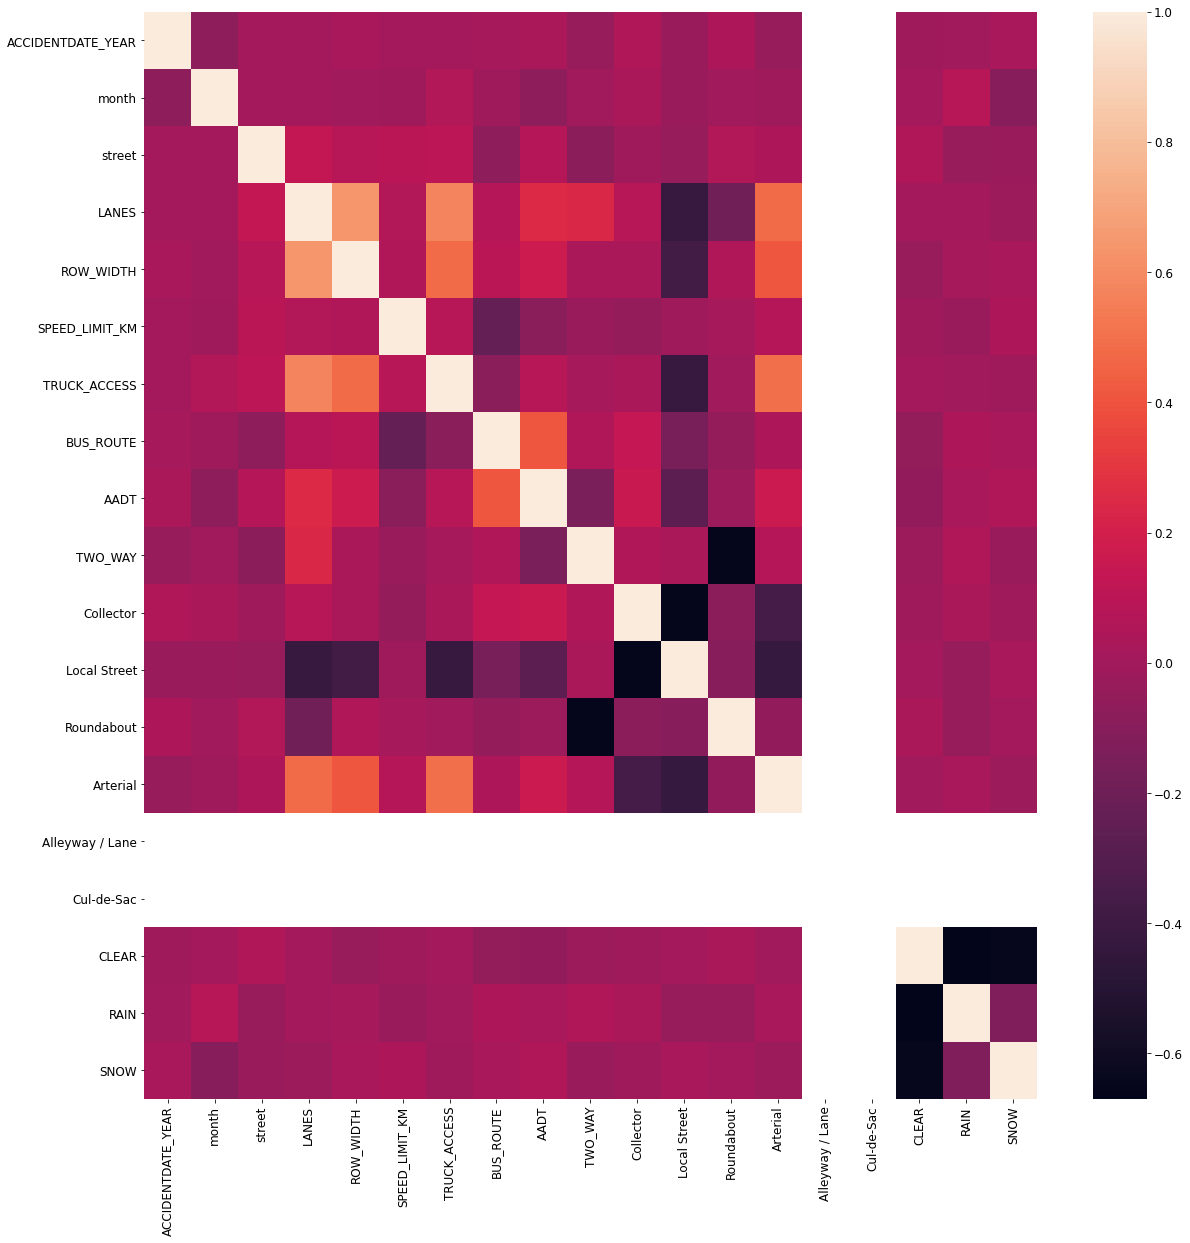

In [67]:
import seaborn as sns
plt.figure(figsize=(20,20))
sns.heatmap(TC.corr())
plt.show()

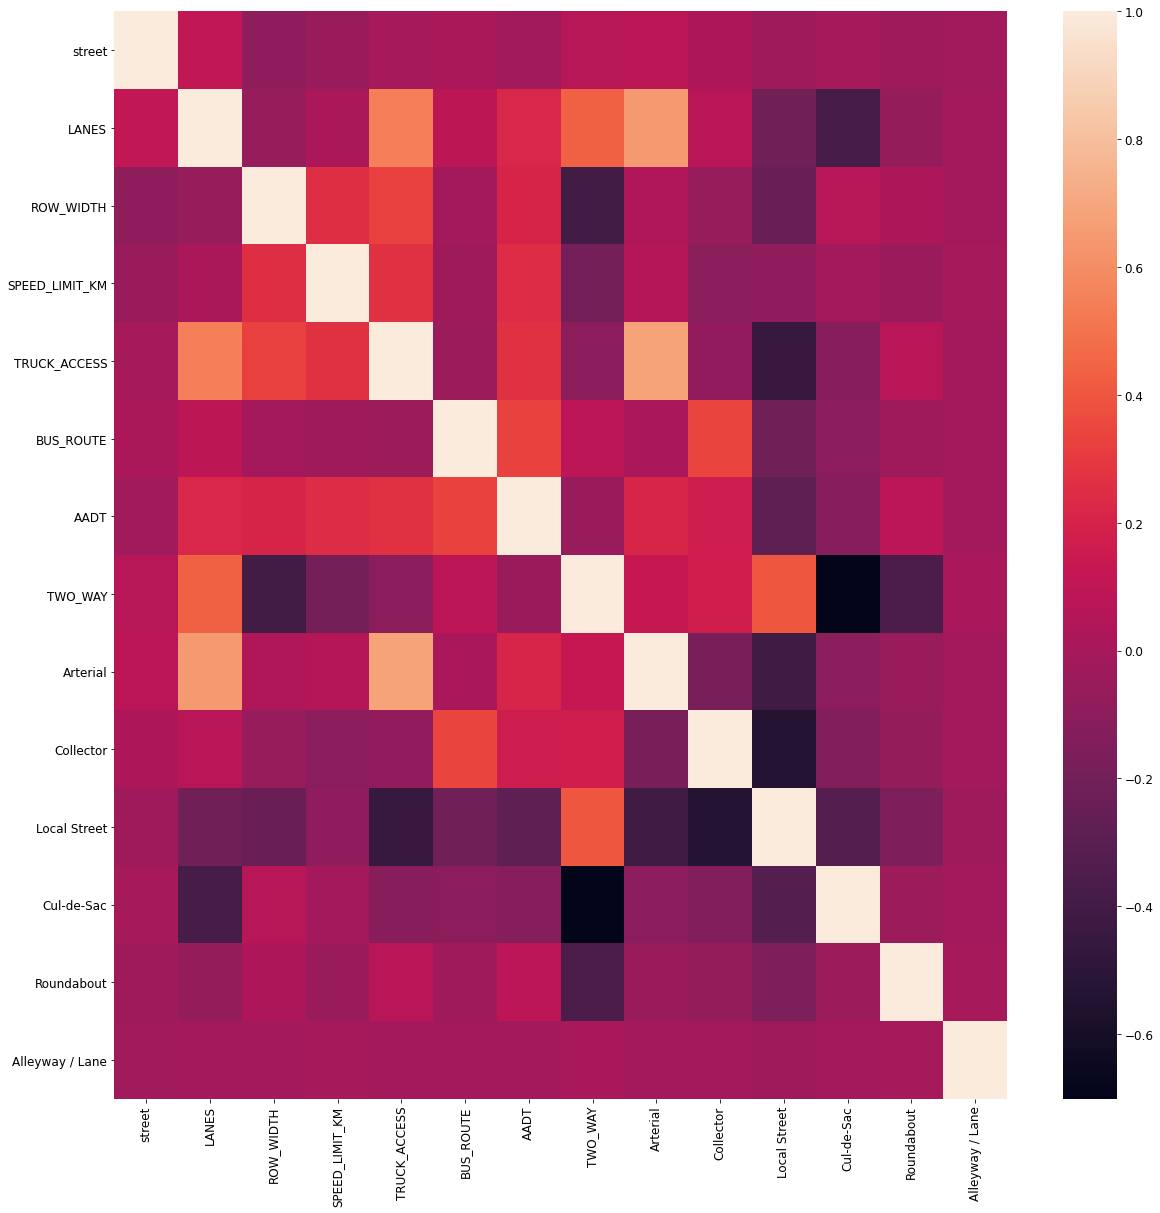

In [68]:
import seaborn as sns
plt.figure(figsize=(20,20))
sns.heatmap(R.corr())
plt.show()

#### Final Dataset
Get the final dataset in which there are both the original accidents and the other instances non-accidents to make us able to train models based on the probability of making an accident.
####(!!caution very cpu demanding!!) 

In [69]:
samples = samples.merge(R,how='left', on = 'street')

In [70]:
samples = pd.get_dummies(samples, columns = ['weather'])
samples=samples.rename(columns={'weather_0':'CLEAR','weather_1':'RAIN','weather_2':'SNOW'})

In [71]:
n_coll = TC.groupby(['ACCIDENTDATE_YEAR', 'month', 'street', 'CLEAR', 'RAIN', 'SNOW']).count().reset_index().iloc[:,:7]

In [72]:
n_coll = n_coll.rename(columns= {'LANES': 'n_collisions'})

In [ ]:
# Matching between the dataset of collisions and samples:
# If a row of collisions is in samples, 1 to is_collision samples column, else 0

samples['is_collision'] = 0
from tqdm import tqdm as tqdm
for i in tqdm(n_coll.index):
    samples.loc[samples[((samples['month']%12) == (n_coll.loc[i,'month']-1)) & 
            ((2005+samples['month']/12) == n_coll.loc[i,'ACCIDENTDATE_YEAR']) &
            ((samples['street']) == n_coll.loc[i,'street']) &
            ((samples['CLEAR']) == n_coll.loc[i,'CLEAR']) &
            ((samples['RAIN']) == n_coll.loc[i,'RAIN'])].index,'is_collision'] = 1
    

100%|██████████████████████████████████████████████████████████████████████████████| 1168/1168 [08:46<00:00,  2.22it/s]


In [ ]:
samples.to_csv('working_dataset.csv')

In [ ]:
pd.read_csv('working_dataset.csv')['is_collision'].value_counts()

0    9356416
1       3584
Name: is_collision, dtype: int64

In [74]:
# create a dict: {index_road : [latitude, longitude]}

import geopy
geolocator = geopy.Nominatim(user_agent='***EMAIL***')
d={}
for i in tqdm(list(index_road.keys())):
    try:
        location = geolocator.geocode(i+', KITCHENER')
        d[index_road[i]]=[location.latitude, location.longitude]
    except:
        d[index_road[i]]=[43.452969,-80.495064]

100%|██████████████████████████████████████████████████████████████████████████████| 1755/1755 [14:37<00:00,  2.00it/s]


In [75]:
#Importing dataset
df = pd.read_csv('working_dataset.csv', index_col = 0)

In [78]:
df['LAT'] = df['street'].apply(lambda x: d[x][0])
df['LONG'] = df['street'].apply(lambda x: d[x][1])

In [79]:
del df['street']

In [80]:
#Preprocess the month column to get the seasons instead of the months
df['month']=np.array([(i-1)%4 for i in df['month']])

#Transorm the seasons into dummy variables 
df = pd.get_dummies(df, columns = ['month'])
df=df.rename(columns={'month_0':'winter','month_1':'spring','month_2':'summer','month_3':'autumn'})

In [81]:
df.to_csv('working_dataset.csv')

# PREDICTION MODELS

### Model 1: classification model

In [82]:
#Import packages needed 
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.regularizers import l2

In [83]:
#Importing dataset
df = pd.read_csv('working_dataset.csv', index_col = 0)

In [84]:
df.head()

,LANES,ROW_WIDTH,SPEED_LIMIT_KM,TRUCK_ACCESS,BUS_ROUTE,AADT,TWO_WAY,Arterial,Collector,Local Street,Cul-de-Sac,Roundabout,Alleyway / Lane,CLEAR,RAIN,SNOW,is_collision,LAT,LONG,winter,spring,summer,autumn
0,3.0,36.0,50.0,1.0,0.0,1000.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,43.455776,-80.427725,0,0,0,1
1,3.0,29.0,48.0,0.0,0.0,5059.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0,43.388438,-80.422573,0,0,0,1
2,2.0,14.0,50.0,0.0,0.0,1979.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,43.450933,-80.488239,0,0,1,0
3,2.0,20.0,50.0,0.0,0.0,1308.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0,43.450958,-80.403387,0,0,1,0
4,2.0,20.0,50.0,0.0,0.0,1308.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1,0,0,43.450958,-80.403387,0,0,0,1


In [85]:
#Check how many accidents i have in the partitioned dataset and remove rows with nan (got from the preprocessing)
df=df.dropna()
print(sum(df.is_collision==1))

3584


In [86]:
#split in train and test
X=df.drop(columns=['is_collision'])
y=df['is_collision']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_val,X_train=X_train[:100000],X_train[100000:]
y_val,y_train=y_train[:100000],y_train[100000:]

In [87]:
#Define and apply the scaler, we decided to use a min_max scaler
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
X_val=scaler.transform(X_val)

In [88]:
#Get the shapes of the dataset to set a model and split them 
input_dim=len(df.columns)-1

#model creation
model = Sequential()
model.add(Dense(19, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(Dense(21, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

#train the model
history=model.fit(x=X_train, y=y_train, batch_size=512, epochs=10, verbose=2, callbacks=None, validation_data=(X_val,y_val))

Epoch 1/10
11943/11943 - 9s - loss: 0.0080 - accuracy: 0.9996 - val_loss: 0.0031 - val_accuracy: 0.9997
Epoch 2/10
11943/11943 - 7s - loss: 0.0034 - accuracy: 0.9996 - val_loss: 0.0030 - val_accuracy: 0.9997
Epoch 3/10
11943/11943 - 7s - loss: 0.0033 - accuracy: 0.9996 - val_loss: 0.0029 - val_accuracy: 0.9997
Epoch 4/10
11943/11943 - 7s - loss: 0.0032 - accuracy: 0.9996 - val_loss: 0.0028 - val_accuracy: 0.9997
Epoch 5/10
11943/11943 - 7s - loss: 0.0031 - accuracy: 0.9996 - val_loss: 0.0027 - val_accuracy: 0.9997
Epoch 6/10
11943/11943 - 7s - loss: 0.0030 - accuracy: 0.9996 - val_loss: 0.0027 - val_accuracy: 0.9997
Epoch 7/10
11943/11943 - 7s - loss: 0.0030 - accuracy: 0.9996 - val_loss: 0.0026 - val_accuracy: 0.9997
Epoch 8/10
11943/11943 - 7s - loss: 0.0029 - accuracy: 0.9996 - val_loss: 0.0026 - val_accuracy: 0.9997
Epoch 9/10
11943/11943 - 7s - loss: 0.0029 - accuracy: 0.9996 - val_loss: 0.0026 - val_accuracy: 0.9997
Epoch 10/10
11943/11943 - 7s - loss: 0.0029 - accuracy: 0.9996 -

In [89]:
#Test the accuracy on accident category and not 
y_predict=model.predict(X_test)

#Check how many instnces are predicted as accident
#Threshold set manually to get a balance between true positive and true negative preferring the true negative (accidents)
y_predict=model.predict(X_test)
sum(y_predict>0.19)

array([0])

In [90]:
#Set a threshold of 0.19 to decide if one instance is an accident or not
y_predict_refined=np.array([i>0.19 for i in y_predict])*1
ris=pd.crosstab(np.array(y_test).reshape(3060922,), np.array(y_predict_refined).reshape(3060922,), rownames=['True'], colnames=['Predicted'], margins=True)
print(ris)

Predicted        0      All
True                       
0          3059761  3059761
1             1161     1161
All        3060922  3060922


###### As we can see, even if the model has an high accuracy, it cannot map the accident, so it results unuseful


#### Now, we try to balance the dataset, to have a fair training on accident and non-accident

In [91]:
#Try to use use smote to make the dataset balanced
#Since we had a very umbalanced dataset
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.datasets import make_classification
sm = SMOTE( random_state=123 )
X_train_smoted, y_train_smoted = sm.fit_resample(X_train, y_train)

In [101]:
#Get the shapes of the dataset to set a model and split them 
input_dim=len(df.columns)-1

#model creation
model = Sequential()
model.add(Dense(19, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(Dense(21, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

#train the model on the smoted dataset to have a fair training of both accident or not
history=model.fit(x=X_train_smoted, y=y_train_smoted, batch_size=512, epochs=10, verbose=2, callbacks=None, validation_data=(X_val,y_val))

Epoch 1/10
23876/23876 - 14s - loss: 0.2450 - accuracy: 0.8947 - val_loss: 0.2882 - val_accuracy: 0.8252
Epoch 2/10
23876/23876 - 13s - loss: 0.2180 - accuracy: 0.9046 - val_loss: 0.2646 - val_accuracy: 0.8421
Epoch 3/10
23876/23876 - 13s - loss: 0.1997 - accuracy: 0.9127 - val_loss: 0.2339 - val_accuracy: 0.8586
Epoch 4/10
23876/23876 - 14s - loss: 0.1874 - accuracy: 0.9226 - val_loss: 0.2230 - val_accuracy: 0.8712
Epoch 5/10
23876/23876 - 15s - loss: 0.1784 - accuracy: 0.9267 - val_loss: 0.2313 - val_accuracy: 0.8697
Epoch 6/10
23876/23876 - 15s - loss: 0.1721 - accuracy: 0.9295 - val_loss: 0.2160 - val_accuracy: 0.8863
Epoch 7/10
23876/23876 - 15s - loss: 0.1682 - accuracy: 0.9313 - val_loss: 0.2102 - val_accuracy: 0.8900
Epoch 8/10
23876/23876 - 14s - loss: 0.1657 - accuracy: 0.9326 - val_loss: 0.2355 - val_accuracy: 0.8824
Epoch 9/10
23876/23876 - 13s - loss: 0.1634 - accuracy: 0.9336 - val_loss: 0.2112 - val_accuracy: 0.8919
Epoch 10/10
23876/23876 - 13s - loss: 0.1611 - accuracy

In [102]:
#Test the accuracy on accident category and not again to check improvements
#Threshold set manually to get a balance between true positive and true negative preferring the true negative (accidents)
y_predict=model.predict(X_test)
y_predict_refined=np.array([i>0.19 for i in y_predict])*1
ris=pd.crosstab(np.array(y_test), np.array(y_predict_refined).reshape(3060922,), rownames=['True'], colnames=['Predicted'], margins=True)
print(ris)

Predicted        0       1      All
True                               
0          2568651  491110  3059761
1                5    1156     1161
All        2568656  492266  3060922


In [103]:
#Check the error 
print('The error on non-accidents is ', round(ris.iloc[0,1]/ris.iloc[0,2]*100,2), '%')
print('The error on accidents is ', round(ris.iloc[1,0]/ris.iloc[1,2]*100,2), '%')

The error on non-accidents is  16.05 %
The error on accidents is  0.43 %


It's a good model because we are more interested in having a high precision: a false positive (a safe road which is labeled risky) is not a problem as a false negative (a risky road that is labeled as safe).

### Model 2 : regression model

This model returns a "risk rate" for each sample: <br>
0 --> low risk <br>
1 --> high risk

In [104]:
#Get the shapes of the dataset to set a model and split them 
input_dim=len(df.columns)-1
input_dim

#model creation
model = Sequential()
model.add(Dense(100, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='mse', optimizer='RMSprop', metrics=['accuracy'])

#train the model
history=model.fit(X_train,y_train,epochs=10,verbose=1,batch_size=5000)

Epoch 1/10
1223/1223 [==============================] - 6s 4ms/step - loss: 0.0080 - accuracy: 0.9969
Epoch 2/10
1223/1223 [==============================] - 5s 4ms/step - loss: 3.8223e-04 - accuracy: 0.9996
Epoch 3/10
1223/1223 [==============================] - 5s 4ms/step - loss: 3.8094e-04 - accuracy: 0.9996
Epoch 4/10
1223/1223 [==============================] - 5s 4ms/step - loss: 3.8081e-04 - accuracy: 0.9996
Epoch 5/10
1223/1223 [==============================] - 5s 4ms/step - loss: 3.8536e-04 - accuracy: 0.9996
Epoch 6/10
1223/1223 [==============================] - 5s 4ms/step - loss: 3.7215e-04 - accuracy: 0.9996
Epoch 7/10
1223/1223 [==============================] - 6s 5ms/step - loss: 4.0635e-04 - accuracy: 0.9996
Epoch 8/10
1223/1223 [==============================] - 6s 5ms/step - loss: 4.0121e-04 - accuracy: 0.9996
Epoch 9/10
1223/1223 [==============================] - 6s 5ms/step - loss: 3.8471e-04 - accuracy: 0.9996
Epoch 10/10
1223/1223 [===========================

##### inspect some results

In [105]:
l=list(df.columns)
l.remove('is_collision')
y_pred=model.predict(X_test)
resulting_df=pd.DataFrame(scaler.inverse_transform(X_test),columns=l)
resulting_df['risk_factor']=y_pred
resulting_df=resulting_df.sort_values(by=['risk_factor'],ascending=False)

In [106]:
pd.set_option('display.max_columns', None)

In [107]:
index_road=pd.read_csv('prob_car_in_street.csv', index_col = 'STREET')
index_road['prob_car_in_street']= range(1,len(index_road)+1)
index_road=index_road['prob_car_in_street'].to_dict()
index_road
inv_index_road = {v: k for k, v in index_road.items()}

In [108]:
resulting_df=resulting_df.drop_duplicates()
resulting_df.head(30)

,LANES,ROW_WIDTH,SPEED_LIMIT_KM,TRUCK_ACCESS,BUS_ROUTE,AADT,TWO_WAY,Arterial,Collector,Local Street,Cul-de-Sac,Roundabout,Alleyway / Lane,CLEAR,RAIN,SNOW,LAT,LONG,winter,spring,summer,autumn,risk_factor
2383513,3.0,29.0,48.0,0.0,0.0,5059.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,43.388438,-80.422574,0.0,0.0,0.0,1.0,0.065367
1304510,3.0,29.0,48.0,0.0,0.0,5059.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,43.388438,-80.422574,0.0,0.0,0.0,1.0,0.065367
1758567,2.0,17.0,50.0,0.0,0.0,1541.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,43.442121,-80.497009,0.0,0.0,0.0,1.0,0.038664
1464131,2.0,14.0,50.0,0.0,0.0,1979.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,43.450933,-80.488239,0.0,0.0,0.0,1.0,0.036908
1550431,2.0,14.0,50.0,0.0,0.0,1979.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,43.450933,-80.488239,0.0,0.0,0.0,1.0,0.036908
858122,2.0,10.0,50.0,0.0,0.0,625.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,43.372756,-80.438533,0.0,0.0,0.0,1.0,0.036808
2682623,2.0,14.0,50.0,0.0,0.0,100.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,43.369407,-80.422699,0.0,0.0,0.0,1.0,0.035797
2022341,2.0,14.0,50.0,0.0,0.0,100.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,43.369407,-80.422699,0.0,0.0,0.0,1.0,0.035797
494474,2.0,13.0,50.0,0.0,0.0,1000.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,43.449649,-80.481520,0.0,0.0,0.0,1.0,0.032208
2819198,2.0,13.0,50.0,0.0,0.0,1000.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,43.449649,-80.481520,0.0,0.0,0.0,1.0,0.032208


In [109]:
resulting_df.groupby(by=['LONG','LAT']).risk_factor.mean().sort_values(ascending=False)

LONG         LAT      
-80.422574   43.388438    8.675593e-03
-80.422699   43.369407    5.093721e-03
-80.488239   43.450933    4.147233e-03
-80.443844   43.464455    3.908409e-03
-80.481520   43.449649    3.665782e-03
                              ...     
-80.500001   43.447732    4.869341e-07
-80.496906   43.460082    4.574259e-07
-80.490137   43.443434    4.103432e-07
-80.484850   43.456161    3.966765e-07
-116.331493  49.156752    1.591966e-12
Name: risk_factor, Length: 1673, dtype: float32

In [110]:
resulting_df.groupby(by=['SNOW']).risk_factor.mean().sort_values(ascending=False)

SNOW
1.0    0.000320
0.0    0.000084
Name: risk_factor, dtype: float32

In [111]:
resulting_df.groupby(by=['RAIN']).risk_factor.mean().sort_values(ascending=False)

RAIN
0.0    0.000218
1.0    0.000044
Name: risk_factor, dtype: float32

In [112]:
resulting_df.groupby(by=['CLEAR']).risk_factor.mean().sort_values(ascending=False)

CLEAR
0.0    0.000178
1.0    0.000124
Name: risk_factor, dtype: float32

In [113]:
resulting_df.groupby(by=['TRUCK_ACCESS']).risk_factor.mean().sort_values(ascending=False)

TRUCK_ACCESS
1.0    0.000356
0.0    0.000151
Name: risk_factor, dtype: float32

In [114]:
resulting_df.groupby(by=['TWO_WAY']).risk_factor.mean().sort_values(ascending=False)

TWO_WAY
1.0    0.000199
0.0    0.000020
Name: risk_factor, dtype: float32

In [115]:
resulting_df.SPEED_LIMIT_KM=(resulting_df.SPEED_LIMIT_KM/10).round()
resulting_df.groupby(by=['SPEED_LIMIT_KM']).risk_factor.mean().sort_values(ascending=False)

SPEED_LIMIT_KM
4.0    1.038606e-03
3.0    2.747488e-04
6.0    1.579044e-04
5.0    1.481713e-04
8.0    1.783011e-06
7.0    1.199582e-06
9.0    4.062858e-08
Name: risk_factor, dtype: float32

#### Importance of the single features on the risk to have an accident

In [116]:
X_train_summary = pd.DataFrame(X_train,columns=l).drop_duplicates()
X_test_summary = pd.DataFrame(X_test,columns=l).drop_duplicates().loc[:10]

step_1


  0%|          | 0/11 [00:00<?, ?it/s]

step_2


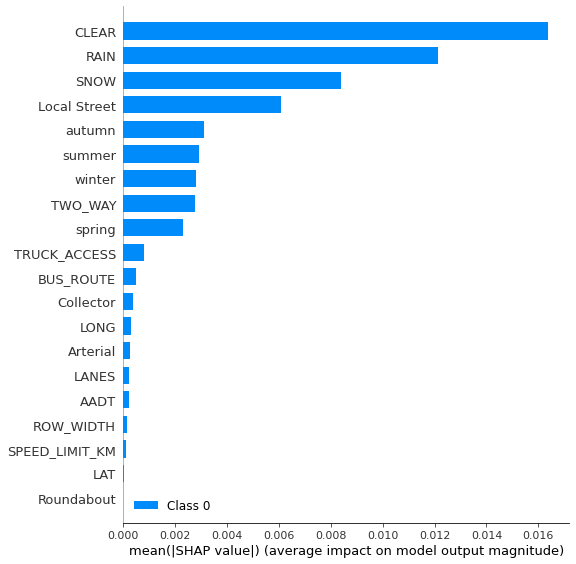

In [117]:
import shap
X_train_summary=shap.kmeans(X_train_summary,100)
#X_test_summary=shap.kmeans(X_test_summary,100)
explainer = shap.KernelExplainer(model.predict, X_train_summary)
print('step_1')
shap_values = explainer.shap_values(X_test_summary)
print('step_2')
shap.summary_plot(shap_values, X_test_summary)

In [118]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test_summary)

###### We can assume that the weather has a strong impact on the risk factor for accidents.

## Conclusions
The first important consequence of our results is that having located the most dangerous roads, the city of Kitchener can investigate whether there are problems in the structure of these roads or if they handle well some weather conditions. For instance, winter resulted more dangerous: its the weather itself or the city has poor measures against cold/snow?
Having built a predictive model of traffic accidents, the information that it gives can be integrated with the car navigators. For example, the choice of taking the safest routes. Moreover, with weather sensors, an intelligent car could signal in advance if a road is dangerous in particular weather conditions. 
This type of study can be done in every city that has this data.
Applied wider, the model can be applied to an entire country and in this way, we can start thinking about an intelligent and safer nation.



### Future Work
With more detailed data regarding the state of the street and the hour of the day, and especially more powerful machines, it's possible to build a more accurate model.
